**这个Notebook需要dmg文件夹中文件, 其他函数在Notebook中定义.**

## Package Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import autograd.numpy as np
from autograd import grad
import pyamg
import dmg.gallery as gallery
import dmg.dgmg as dgmg
import dmg.gmg_linear as gmg_linear
import dmg.classical_amg as classical_amg

## Define R, P, Poisson, Nonlinear Poisson

In [2]:
def Restriction(inputsize):
    inputsize = int(inputsize)
    sqrtinputsize = int(np.sqrt(inputsize))
    outputsize = int((2**(np.log2(np.sqrt(inputsize)+1)-1)-1)**2)
    sqrtoutputsize = int(np.sqrt(outputsize))
    OUTPUT = np.zeros([outputsize, inputsize])
    for j in range(sqrtoutputsize):
        for i in range(sqrtoutputsize):
            OUTPUT[i+sqrtoutputsize*j][2*i+j*2*sqrtinputsize] = 1/16
            OUTPUT[i+sqrtoutputsize*j][1+2*i+j*2*sqrtinputsize] = 1/8
            OUTPUT[i+sqrtoutputsize*j][2+2*i+j*2*sqrtinputsize] = 1/16
            OUTPUT[i+sqrtoutputsize*j][sqrtinputsize +
                                       2*i+j*2*sqrtinputsize] = 1/8
            OUTPUT[i+sqrtoutputsize*j][1+sqrtinputsize +
                                       2*i+j*2*sqrtinputsize] = 1/4
            OUTPUT[i+sqrtoutputsize*j][2+sqrtinputsize +
                                       2*i+j*2*sqrtinputsize] = 1/8
            OUTPUT[i+sqrtoutputsize*j][2*sqrtinputsize +
                                       2*i+j*2*sqrtinputsize] = 1/16
            OUTPUT[i+sqrtoutputsize*j][1+2 *
                                       sqrtinputsize + 2*i+j*2*sqrtinputsize] = 1/8
            OUTPUT[i+sqrtoutputsize*j][2+2 *
                                       sqrtinputsize+2*i+j*2*sqrtinputsize] = 1/16
    return OUTPUT

def Poisson(inputsize):
    inputsize = int(inputsize)
    sqrtinputsize = int(np.sqrt(inputsize))
    A1 = 2*np.eye(sqrtinputsize)
    for i in range(sqrtinputsize-1):
        A1[i, i+1] = -1
        A1[i+1, i] = -1
    I = np.eye(sqrtinputsize)
    OUTPUT = (np.kron(I, A1)+np.kron(A1, I))
    return OUTPUT


def NonlinearPoisson(inputsize):
    inputsize = int(inputsize)
    sqrtinputsize = int(np.sqrt(inputsize))
    h = 1/(sqrtinputsize-1)
    KX = np.zeros([inputsize,inputsize+1])
    KY = np.zeros([inputsize+1,inputsize])
    for i in range(sqrtinputsize):
        for j in range(sqrtinputsize+1):
            KX[i][j] = a(j*h-0.5*h,i*h)
    for i in range(sqrtinputsize+1):
        for j in range(sqrtinputsize):
            KY[i][j] = a(j*h,i*h-0.5*h)
    OUTPUT = (gallery.nonlinearPoisson((sqrtinputsize,sqrtinputsize),KX,KY)).to_full()
    return OUTPUT

## Define Multigrid

In [3]:
def Multigrid_circle(inputsize, A_A, B, R_A, s, w, NUM_EPOCH):
    A = np.matrix(A_A)
    P = 4*np.transpose(R_A)
    R = np.matrix(R_A)
    M = np.matrix(w**(-1)*np.diag(np.diag(A)))
    K = M - A
    C = np.linalg.inv(M)*K
    b = np.linalg.inv(M)*B
    U0 = np.matrix(np.zeros([inputsize, 1]))
    RESIDUAL = []
    for i in range(NUM_EPOCH):
        for j in range(s):
            U0 = C*U0+b
        r = B - A*U0
        Residual = np.linalg.norm(r,2)
        rc = R*r
        Ac = R*A*P
        Uc = np.linalg.solve(Ac, rc)
        U = U0 + P*Uc
        for k in range(s):
            U = C*U+b
        U0 = U
        RESIDUAL.append(Residual)
        print("Residual = {}".format(Residual))
        print("Interation = {}".format(i))
        print("===================")
    return U0, RESIDUAL

## Define Spectral Radius Calculator

In [4]:
def rho(inputsize,A,P,R,w,s):
    M = (w**(-1)) * np.diag(np.diag(A))
    K = M - A
    MK = np.matmul(np.linalg.inv(M),K)
    I = np.eye(inputsize)
    IPRAPRA = I - np.matmul(np.matmul(np.matmul(P,np.linalg.inv(np.matmul(np.matmul(R,A),P))),R),A)
    C = np.matmul(np.matmul(MK,IPRAPRA),MK)
    for i in range(5):
        C = np.matmul(C,C)
    radius = np.linalg.norm(C)**(1/32)
    return radius

def rhoAuto(INPUT):
    R = INPUT[0]
    w = INPUT[1]
    P = 4*np.transpose(R)
    M = (w**(-1)) * np.diag(np.diag(A1))
    K = M - A1
    MK = np.matmul(np.linalg.inv(M),K)
    I = np.eye(inputsize)
    IPRAPRA = I - np.matmul(np.matmul(np.matmul(P,np.linalg.inv(np.matmul(np.matmul(R,A1),P))),R),A1)
    C = np.matmul(np.matmul(MK,IPRAPRA),MK)
    for i in range(5):
        C = np.matmul(C,C)
    radius = np.linalg.norm(C)**(1/32)
    return radius

## Define Optimizer

In [5]:
def optimizer_GD(inputsize, A, R, w, s, learning_rate):
    rhoold = rho(inputsize,A,4*np.transpose(R),R,w,s)
    INPUT = [R,w]
    rhoGra = grad(rhoAuto)
    delta = rhoGra(INPUT)
    R -= learning_rate*delta[0]
    w -= learning_rate*delta[1]
    rhonew = rho(inputsize,A,4*np.transpose(R),R,w,s)
    return R, w, rhoold, rhonew

def direct_optimizer_GD(inputsize, A0, A1, R, w, s, learning_rate):
    Rhoold = rho(inputsize,A1,4*np.transpose(R),R,w,s)
    Rhonew = [Rhoold]
    for i in range(100):
        Rnew, wnew, rhoold, rhonew = optimizer_GD(inputsize, A1, R, w, s, learning_rate)
        R = Rnew
        w = wnew
        print("rho = {}".format(rhonew))
        print("===================")
        Rhonew.append(rhonew)
        i+=1
    print("======End======")
    return R, w, Rhoold, Rhonew

def homotopy_optimizer_GD(inputsize, A0, A1, R, w, s, learning_rate ,accept_radius ,step_length):
    Rhoold = rho(inputsize,A1,4*np.transpose(R),R,w,s)
    Radius = [Rhoold]
    L = step_length
    print("======Section 1======")
    while L < 1:
        M = (1-L)*A0 + L*A1
        Rnew, wnew, rhoold, rhonew = optimizer_GD(inputsize, M, R, w, s, learning_rate)
        Radius.append(rhonew)
        if rhonew > accept_radius:
            step_length = 0.1*step_length
            learning_rate = 0.1*learning_rate
            print('Decrease the step_length, learning_rate and Restart!!')
            print("step_length = {}".format(step_length))      
            print("learning_rate = {}".format(learning_rate))
            print("rhonew = {}".format(rhonew))
            print("===================")
            R = Restriction(inputsize)
            P = 4*np.transpose(R)
            w = 2/3
            L = step_length
        else:
            R = Rnew
            w = wnew
            L += step_length
            print("L = {}".format(L))
            print("rho = {}".format(rhonew))
            print("===================")
    print("======Section 2======")
    i = 0
    while rhonew <= rhoold and i<100:
        Rnew, wnew, rhoold, rhonew = optimizer_GD(inputsize, A1, R, w, s, learning_rate)
        R = Rnew
        Radius.append(Rnew)
        w = wnew
        print("rho = {}".format(rhonew))
        print("===================")
        i+=1
    Rhonew = rhonew
    print("======End======")
    return R, w, Rhoold, Rhonew, Radius

In [6]:
finegridsize = 5
s = 1
w = 2/3
MAX_ITER = 50

# Experiment (with large e1, e2, e3, e4, e5)

选取比较大的参数, a函数频率较小

In [7]:
e = 0.0001
def u_real(x, y): return np.sin(np.pi*3*x)*np.sin(np.pi*5*y)
def rightf(x, y): return  34*np.pi**2*np.sin(3*np.pi*x)*np.sin(5*np.pi*y)*(np.cos((x + y)/e) + 2) + (3*np.pi*np.cos(3*np.pi*x)*np.sin(5*np.pi*y)*np.sin((x + y)/e))/e + (5*np.pi*np.cos(5*np.pi*y)*np.sin(3*np.pi*x)*np.sin((x + y)/e))/e
def a(x, y): return 2+np.cos((x+y)/e)

**Plot $a(x,y)$**

In [8]:
inputsize = (2**finegridsize-1)**2
inputsize = int(inputsize)
sqrtinputsize = int(np.sqrt(inputsize))
outputsize = int((2**(np.log2(np.sqrt(inputsize)+1)-1)-1)**2)
sqrtoutputsize = int(np.sqrt(outputsize))
h = 1/(sqrtinputsize-1)
A0 = Poisson(inputsize)
A1 = NonlinearPoisson(inputsize)
[X, Y] = np.meshgrid(np.linspace(0, 1, sqrtinputsize),np.linspace(0, 1, sqrtinputsize))
RightF = rightf(X,Y)*h**2
RightF = RightF.reshape(inputsize, 1)
Ureal = u_real(X,Y).reshape(inputsize, 1)
R = Restriction(inputsize)
P = 4*np.transpose(R)

**Plot A0, A1**

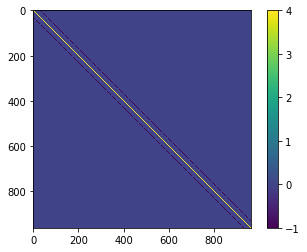

In [9]:
plt.imshow(A0)
plt.colorbar()

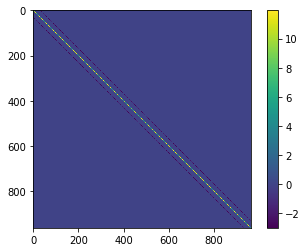

In [10]:
plt.imshow(A1)
plt.colorbar()


## GMM

**Calculate Result and Residual**

In [11]:
GMM_U, GMM_Res = Multigrid_circle(inputsize, A1, RightF, R, s, w, MAX_ITER)

Residual = 1992.7775320252833
Interation = 0
Residual = 297.9965829940765
Interation = 1
Residual = 81.83519318163391
Interation = 2
Residual = 27.445916759598095
Interation = 3
Residual = 10.258399282533954
Interation = 4
Residual = 4.061748125954633
Interation = 5
Residual = 1.6600115552511077
Interation = 6
Residual = 0.6909136573047017
Interation = 7
Residual = 0.2907606248091519
Interation = 8
Residual = 0.1232350079859565
Interation = 9
Residual = 0.05248582455035479
Interation = 10
Residual = 0.022432497663443667
Interation = 11
Residual = 0.009613428838253781
Interation = 12
Residual = 0.004128638978366318
Interation = 13
Residual = 0.0017762360339818328
Interation = 14
Residual = 0.000765319602092556
Interation = 15
Residual = 0.00033017650525805296
Interation = 16
Residual = 0.00014260778781697471
Interation = 17
Residual = 6.16567218091655e-05
Interation = 18
Residual = 2.6681731460704524e-05
Interation = 19
Residual = 1.1556002192933232e-05
Interation = 20
Residual = 5.0087

In [12]:
np.linalg.norm(Ureal - GMM_U,np.inf)

1290.2722716826177

**Plot Result**

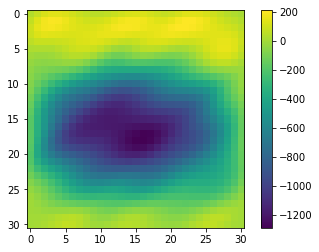

In [13]:
plt.imshow(GMM_U.reshape(sqrtinputsize,sqrtinputsize))
plt.colorbar()

**Plot Residual**

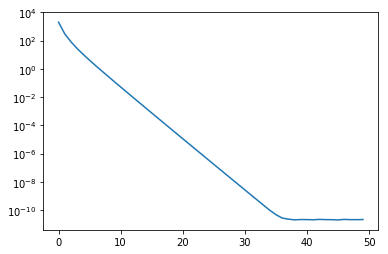

In [14]:
plt.semilogy(GMM_Res)

**Calculate Spectral Radius**

In [15]:
GMM_Radius = rho(inputsize,A1,4*np.transpose(R),R,w,s)
print('GMM_Radius = {}'.format(GMM_Radius))

GMM_Radius = 0.4548760488694402


## AMG

**Define Solver and Solve**

In [16]:
amg_solver = pyamg.classical.classical.ruge_stuben_solver(A1,max_levels = 2)
pyamg.relaxation.smoothing.change_smoothers(amg_solver,presmoother=("jacobi", {"omega": w, "iterations": s}),postsmoother=("jacobi", {"omega": w, "iterations": s}))
AMG_Res = []
print(amg_solver)
AMG_U= amg_solver.solve(RightF, maxiter = MAX_ITER, tol=0, residuals=AMG_Res)

multilevel_solver
Number of Levels:     2
Operator Complexity:  1.872
Grid Complexity:      1.501
Coarse Solver:        'pinv2'
  level   unknowns     nonzeros
    0          961         4681 [53.42%]
    1          481         4081 [46.58%]



/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pyamg/classical/classical.py:98: SparseEfficiencyWarning: Implicit conversion of A to CSR
  SparseEfficiencyWarning)


**Plot Result**

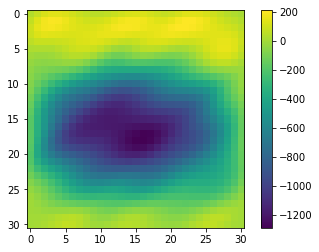

In [17]:
plt.imshow(AMG_U.reshape(sqrtinputsize,sqrtinputsize))
plt.colorbar()

**Plot Residual**

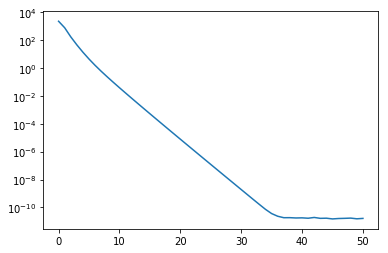

In [18]:
plt.semilogy(AMG_Res)

## DMM with full R optimization

**Optimize R, P, $\omega$**

learning_rate是梯度下降时步长, step_length是每一个M之间的距离, 两者都必须非常小, 不然会出现不好的结果.

In [19]:
Rnew, wnew, Rhoold, Rhonew, Radius = homotopy_optimizer_GD(inputsize, A0, A1, Restriction(inputsize),  2/3, s, learning_rate = 1e-1,accept_radius = GMM_Radius,step_length = 1e-1)

======Section 1======
L = 0.2
rho = 0.40767980485636507
Decrease the step_length, learning_rate and Restart!!
step_length = 0.010000000000000002
learning_rate = 0.010000000000000002
rhonew = 0.896861513648696
L = 0.020000000000000004
rho = 0.44921585046277046
L = 0.030000000000000006
rho = 0.4443914344202355
L = 0.04000000000000001
rho = 0.4396422841909135
L = 0.05000000000000001
rho = 0.43492684988607344
L = 0.06000000000000001
rho = 0.4303200042571729
L = 0.07
rho = 0.42586181278111535
L = 0.08000000000000002
rho = 0.42304319144269226
Decrease the step_length, learning_rate and Restart!!
step_length = 0.0010000000000000002
learning_rate = 0.0010000000000000002
rhonew = 0.4622285276120302
L = 0.0020000000000000005
rho = 0.4535928840386886
L = 0.003000000000000001
rho = 0.45310493429800147
L = 0.004000000000000001
rho = 0.45261757200813324
L = 0.005000000000000001
rho = 0.45213076385909
L = 0.006000000000000001
rho = 0.4516444946831795
L = 0.007000000000000001
rho = 0.4511587587239427


L = 0.10700000000000008
rho = 0.4052274248344563
L = 0.10800000000000008
rho = 0.4047935044439221
L = 0.10900000000000008
rho = 0.4043600665738602
L = 0.11000000000000008
rho = 0.40392711065493975
L = 0.11100000000000008
rho = 0.4034946361187319
L = 0.11200000000000009
rho = 0.4030626423977038
L = 0.11300000000000009
rho = 0.40263112892521324
L = 0.11400000000000009
rho = 0.4022000951355036
L = 0.11500000000000009
rho = 0.40176954046369795
L = 0.11600000000000009
rho = 0.4013394643457944
L = 0.11700000000000009
rho = 0.40090986621866054
L = 0.11800000000000009
rho = 0.4004807455200294
L = 0.11900000000000009
rho = 0.4000521016884938
L = 0.12000000000000009
rho = 0.3996239341635021
L = 0.1210000000000001
rho = 0.39919624238535384
L = 0.1220000000000001
rho = 0.3987690257951952
L = 0.1230000000000001
rho = 0.3983422838350142
L = 0.1240000000000001
rho = 0.3979160159476377
L = 0.12500000000000008
rho = 0.3974902215767262
L = 0.12600000000000008
rho = 0.39706490016677015
L = 0.127000000000

L = 0.0003000000000000001
rho = 0.4539837339717469
L = 0.00040000000000000013
rho = 0.4539348674378923
L = 0.0005000000000000001
rho = 0.4538860078777261
L = 0.0006000000000000002
rho = 0.4538371551936908
L = 0.0007000000000000002
rho = 0.45378830929352626
L = 0.0008000000000000003
rho = 0.45373947009000126
L = 0.0009000000000000003
rho = 0.4536906375006565
L = 0.0010000000000000002
rho = 0.45364181144756177
L = 0.0011000000000000003
rho = 0.45359299185708424
L = 0.0012000000000000003
rho = 0.45354417865966906
L = 0.0013000000000000004
rho = 0.4534953717896301
L = 0.0014000000000000004
rho = 0.4534465711849516
L = 0.0015000000000000005
rho = 0.4533977767870992
L = 0.0016000000000000005
rho = 0.45334898854084044
L = 0.0017000000000000006
rho = 0.45330020639407514
L = 0.0018000000000000006
rho = 0.453251430297672
L = 0.0019000000000000006
rho = 0.453202660205316
L = 0.0020000000000000005
rho = 0.4531538960733612
L = 0.0021000000000000003
rho = 0.45310513786069206
L = 0.0022
rho = 0.45305

L = 0.012099999999999982
rho = 0.4482569471915261
L = 0.012199999999999982
rho = 0.4482087369034791
L = 0.012299999999999981
rho = 0.44816053200061495
L = 0.01239999999999998
rho = 0.44811233248328586
L = 0.01249999999999998
rho = 0.44806413835182257
L = 0.01259999999999998
rho = 0.44801594960653546
L = 0.012699999999999979
rho = 0.44796776624771334
L = 0.012799999999999978
rho = 0.44791958827562467
L = 0.012899999999999977
rho = 0.4478714156905171
L = 0.012999999999999977
rho = 0.4478232484926177
L = 0.013099999999999976
rho = 0.4477750866821336
L = 0.013199999999999976
rho = 0.4477269302592518
L = 0.013299999999999975
rho = 0.4476787792241391
L = 0.013399999999999974
rho = 0.44763063357694294
L = 0.013499999999999974
rho = 0.44758249331779154
L = 0.013599999999999973
rho = 0.44753435844679357
L = 0.013699999999999973
rho = 0.4474862289640391
L = 0.013799999999999972
rho = 0.44743810486959934
L = 0.013899999999999971
rho = 0.4473899861635272
L = 0.01399999999999997
rho = 0.44734187284

L = 0.02379999999999991
rho = 0.44265286023599526
L = 0.02389999999999991
rho = 0.44260527859644
L = 0.02399999999999991
rho = 0.4425577022983054
L = 0.02409999999999991
rho = 0.4425101313409045
L = 0.02419999999999991
rho = 0.44246256572354936
L = 0.02429999999999991
rho = 0.4424150054455508
L = 0.024399999999999908
rho = 0.442367450506219
L = 0.024499999999999907
rho = 0.4423199009048633
L = 0.024599999999999907
rho = 0.4422723566407919
L = 0.024699999999999906
rho = 0.4422248177133127
L = 0.024799999999999905
rho = 0.44217728412173246
L = 0.024899999999999905
rho = 0.44212975586535735
L = 0.024999999999999904
rho = 0.442082232943493
L = 0.025099999999999904
rho = 0.44203471535544425
L = 0.025199999999999903
rho = 0.4419872031005153
L = 0.025299999999999902
rho = 0.44193969617801016
L = 0.025399999999999902
rho = 0.4418921945872317
L = 0.0254999999999999
rho = 0.4418446983274829
L = 0.0255999999999999
rho = 0.4417972073980659
L = 0.0256999999999999
rho = 0.4417497217982824
L = 0.0257

L = 0.03559999999999999
rho = 0.4370749125569808
L = 0.035699999999999996
rho = 0.4370279563966155
L = 0.0358
rho = 0.4369810054958222
L = 0.0359
rho = 0.43693405985392275
L = 0.036000000000000004
rho = 0.4368871194702397
L = 0.03610000000000001
rho = 0.4368401843440957
L = 0.03620000000000001
rho = 0.43679325447481376
L = 0.03630000000000001
rho = 0.4367463298617175
L = 0.036400000000000016
rho = 0.4366994105041307
L = 0.03650000000000002
rho = 0.4366524964013775
L = 0.03660000000000002
rho = 0.43660558755278234
L = 0.036700000000000024
rho = 0.4365586839576701
L = 0.03680000000000003
rho = 0.43651178561536613
L = 0.03690000000000003
rho = 0.4364648925251959
L = 0.03700000000000003
rho = 0.4364180046864854
L = 0.037100000000000036
rho = 0.4363711220985608
L = 0.03720000000000004
rho = 0.43632424476074877
L = 0.03730000000000004
rho = 0.43627737267237643
L = 0.037400000000000044
rho = 0.4362305058327708
L = 0.03750000000000005
rho = 0.4361836442412596
L = 0.03760000000000005
rho = 0.43

L = 0.047500000000000334
rho = 0.43152387391410424
L = 0.047600000000000336
rho = 0.4314775389711854
L = 0.04770000000000034
rho = 0.4314312092093344
L = 0.04780000000000034
rho = 0.43138488462790725
L = 0.047900000000000345
rho = 0.4313385652262597
L = 0.04800000000000035
rho = 0.43129225100374824
L = 0.04810000000000035
rho = 0.43124594195972926
L = 0.048200000000000354
rho = 0.43119963809355943
L = 0.04830000000000036
rho = 0.4311533394045957
L = 0.04840000000000036
rho = 0.4311070458921952
L = 0.04850000000000036
rho = 0.4310607575557151
L = 0.048600000000000365
rho = 0.43101447439451296
L = 0.04870000000000037
rho = 0.43096819640794665
L = 0.04880000000000037
rho = 0.43092192359537385
L = 0.048900000000000374
rho = 0.430875655956153
L = 0.04900000000000038
rho = 0.4308293934896424
L = 0.04910000000000038
rho = 0.43078313619520014
L = 0.04920000000000038
rho = 0.4307368840721855
L = 0.049300000000000385
rho = 0.4306906371199573
L = 0.04940000000000039
rho = 0.4306443953378745
L = 0

L = 0.05930000000000067
rho = 0.4260919451319637
L = 0.059400000000000674
rho = 0.42604621715986113
L = 0.05950000000000068
rho = 0.426000494294106
L = 0.05960000000000068
rho = 0.4259547765340752
L = 0.05970000000000068
rho = 0.4259090638791454
L = 0.059800000000000686
rho = 0.42586335632869354
L = 0.05990000000000069
rho = 0.4258176538820969
L = 0.06000000000000069
rho = 0.4257719565387327
L = 0.060100000000000695
rho = 0.42572626429797816
L = 0.0602000000000007
rho = 0.425680577159211
L = 0.0603000000000007
rho = 0.4256348951218089
L = 0.0604000000000007
rho = 0.4255892181851498
L = 0.060500000000000706
rho = 0.42554354634861163
L = 0.06060000000000071
rho = 0.4254978796115726
L = 0.06070000000000071
rho = 0.42545221797341093
L = 0.060800000000000715
rho = 0.42540656143350497
L = 0.06090000000000072
rho = 0.42536090999123366
L = 0.06100000000000072
rho = 0.42531526364597544
L = 0.06110000000000072
rho = 0.42526962239710936
L = 0.061200000000000726
rho = 0.42522398624401425
L = 0.061

L = 0.07120000000000101
rho = 0.4206859985811736
L = 0.07130000000000102
rho = 0.4206408739270609
L = 0.07140000000000102
rho = 0.4205957543061047
L = 0.07150000000000102
rho = 0.42055063971769807
L = 0.07160000000000102
rho = 0.4205055301612338
L = 0.07170000000000103
rho = 0.4204604256361051
L = 0.07180000000000103
rho = 0.42041532614170524
L = 0.07190000000000103
rho = 0.42037023167742765
L = 0.07200000000000104
rho = 0.42032514224266576
L = 0.07210000000000104
rho = 0.4202800578368132
L = 0.07220000000000104
rho = 0.4202349784592638
L = 0.07230000000000104
rho = 0.4201899041094113
L = 0.07240000000000105
rho = 0.4201448347866498
L = 0.07250000000000105
rho = 0.42009977049037345
L = 0.07260000000000105
rho = 0.4200547112199764
L = 0.07270000000000106
rho = 0.42000965697485293
L = 0.07280000000000106
rho = 0.41996460775439776
L = 0.07290000000000106
rho = 0.4199195635580053
L = 0.07300000000000106
rho = 0.41987452438507045
L = 0.07310000000000107
rho = 0.419829490234988
L = 0.0732000

L = 0.08310000000000135
rho = 0.41535133725914175
L = 0.08320000000000136
rho = 0.41530680732117126
L = 0.08330000000000136
rho = 0.41526228234494983
L = 0.08340000000000136
rho = 0.4152177623298843
L = 0.08350000000000136
rho = 0.41517324727538146
L = 0.08360000000000137
rho = 0.41512873718084836
L = 0.08370000000000137
rho = 0.4150842320456923
L = 0.08380000000000137
rho = 0.41503973186932036
L = 0.08390000000000138
rho = 0.41499523665114
L = 0.08400000000000138
rho = 0.4149507463905588
L = 0.08410000000000138
rho = 0.41490626108698414
L = 0.08420000000000138
rho = 0.4148617807398238
L = 0.08430000000000139
rho = 0.41481730534848565
L = 0.08440000000000139
rho = 0.41477283491237754
L = 0.0845000000000014
rho = 0.4147283694309074
L = 0.0846000000000014
rho = 0.41468390890348344
L = 0.0847000000000014
rho = 0.414639453329514
L = 0.0848000000000014
rho = 0.4145950027084073
L = 0.0849000000000014
rho = 0.4145505570395719
L = 0.08500000000000141
rho = 0.4145061163224163
L = 0.085100000000

L = 0.0950000000000017
rho = 0.4100869495109135
L = 0.0951000000000017
rho = 0.4100430058856688
L = 0.0952000000000017
rho = 0.40999906715232964
L = 0.0953000000000017
rho = 0.40995513331031547
L = 0.0954000000000017
rho = 0.4099112043590455
L = 0.09550000000000171
rho = 0.4098672802979391
L = 0.09560000000000171
rho = 0.40982336112641604
L = 0.09570000000000171
rho = 0.40977944684389567
L = 0.09580000000000172
rho = 0.4097355374497979
L = 0.09590000000000172
rho = 0.4096916329435425
L = 0.09600000000000172
rho = 0.4096477333245494
L = 0.09610000000000173
rho = 0.4096038385922386
L = 0.09620000000000173
rho = 0.4095599487460302
L = 0.09630000000000173
rho = 0.40951606378534433
L = 0.09640000000000173
rho = 0.40947218370960153
L = 0.09650000000000174
rho = 0.40942830851822215
L = 0.09660000000000174
rho = 0.40938443821062664
L = 0.09670000000000174
rho = 0.4093405727862356
L = 0.09680000000000175
rho = 0.40929671224446984
L = 0.09690000000000175
rho = 0.4092528565847501
L = 0.0970000000

L = 0.10690000000000204
rho = 0.4048918459240388
L = 0.10700000000000204
rho = 0.40484848038452886
L = 0.10710000000000204
rho = 0.4048051196684884
L = 0.10720000000000204
rho = 0.4047617637753481
L = 0.10730000000000205
rho = 0.40471841270453857
L = 0.10740000000000205
rho = 0.40467506645549045
L = 0.10750000000000205
rho = 0.40463172502763456
L = 0.10760000000000206
rho = 0.40458838842040185
L = 0.10770000000000206
rho = 0.4045450566332231
L = 0.10780000000000206
rho = 0.4045017296655295
L = 0.10790000000000206
rho = 0.4044584075167522
L = 0.10800000000000207
rho = 0.40441509018632243
L = 0.10810000000000207
rho = 0.4043717776736715
L = 0.10820000000000207
rho = 0.4043284699782309
L = 0.10830000000000208
rho = 0.404285167099432
L = 0.10840000000000208
rho = 0.4042418690367065
L = 0.10850000000000208
rho = 0.4041985757894861
L = 0.10860000000000208
rho = 0.4041552873572025
L = 0.10870000000000209
rho = 0.4041120037392877
L = 0.10880000000000209
rho = 0.40406872493517354
L = 0.10890000

L = 0.11880000000000238
rho = 0.39976505707810955
L = 0.11890000000000238
rho = 0.39972226155757307
L = 0.11900000000000238
rho = 0.3996794707933606
L = 0.11910000000000238
rho = 0.39963668478491315
L = 0.11920000000000239
rho = 0.39959390353167157
L = 0.11930000000000239
rho = 0.3995511270330771
L = 0.1194000000000024
rho = 0.399508355288571
L = 0.1195000000000024
rho = 0.39946558829759454
L = 0.1196000000000024
rho = 0.3994228260595889
L = 0.1197000000000024
rho = 0.3993800685739958
L = 0.1198000000000024
rho = 0.3993373158402568
L = 0.11990000000000241
rho = 0.39929456785781325
L = 0.12000000000000241
rho = 0.3992518246261071
L = 0.12010000000000241
rho = 0.3992090861445801
L = 0.12020000000000242
rho = 0.39916635241267406
L = 0.12030000000000242
rho = 0.39912362342983104
L = 0.12040000000000242
rho = 0.3990808991954931
L = 0.12050000000000242
rho = 0.39903817970910244
L = 0.12060000000000243
rho = 0.39899546497010124
L = 0.12070000000000243
rho = 0.3989527549779317
L = 0.1208000000

L = 0.13070000000000193
rho = 0.3947056318737432
L = 0.13080000000000191
rho = 0.39466339845360404
L = 0.1309000000000019
rho = 0.3946211697238469
L = 0.1310000000000019
rho = 0.39457894568392265
L = 0.13110000000000188
rho = 0.394536726333282
L = 0.13120000000000187
rho = 0.39449451167137606
L = 0.13130000000000186
rho = 0.3944523016976556
L = 0.13140000000000185
rho = 0.3944100964115718
L = 0.13150000000000184
rho = 0.39436789581257603
L = 0.13160000000000183
rho = 0.39432569990011934
L = 0.13170000000000182
rho = 0.3942835086736531
L = 0.1318000000000018
rho = 0.3942413221326286
L = 0.1319000000000018
rho = 0.39419914027649755
L = 0.13200000000000178
rho = 0.39415696310471143
L = 0.13210000000000177
rho = 0.39411479061672183
L = 0.13220000000000176
rho = 0.3940726228119807
L = 0.13230000000000175
rho = 0.3940304596899396
L = 0.13240000000000174
rho = 0.3939883012500507
L = 0.13250000000000173
rho = 0.39394614749176554
L = 0.13260000000000172
rho = 0.39390399841453666
L = 0.132700000

L = 0.14260000000000062
rho = 0.3897126362931728
L = 0.1427000000000006
rho = 0.3896709571941567
L = 0.1428000000000006
rho = 0.3896292827207221
L = 0.14290000000000058
rho = 0.38958761287232957
L = 0.14300000000000057
rho = 0.3895459476484393
L = 0.14310000000000056
rho = 0.38950428704851153
L = 0.14320000000000055
rho = 0.38946263107200696
L = 0.14330000000000054
rho = 0.38942097971838613
L = 0.14340000000000053
rho = 0.3893793329871095
L = 0.14350000000000052
rho = 0.3893376908776379
L = 0.1436000000000005
rho = 0.389296053389432
L = 0.1437000000000005
rho = 0.38925442052195286
L = 0.14380000000000048
rho = 0.3892127922746613
L = 0.14390000000000047
rho = 0.38917116864701834
L = 0.14400000000000046
rho = 0.3891295496384853
L = 0.14410000000000045
rho = 0.38908793524852314
L = 0.14420000000000044
rho = 0.38904632547659324
L = 0.14430000000000043
rho = 0.3890047203221571
L = 0.14440000000000042
rho = 0.38896311978467607
L = 0.1445000000000004
rho = 0.38892152386361156
L = 0.1446000000

L = 0.1545999999999993
rho = 0.3847440202153521
L = 0.15469999999999928
rho = 0.3847028923590607
L = 0.15479999999999927
rho = 0.3846617690643591
L = 0.15489999999999926
rho = 0.38462065033072607
L = 0.15499999999999925
rho = 0.3845795361576408
L = 0.15509999999999924
rho = 0.384538426544583
L = 0.15519999999999923
rho = 0.3844973214910326
L = 0.15529999999999922
rho = 0.38445622099647037
L = 0.1553999999999992
rho = 0.38441512506037734
L = 0.1554999999999992
rho = 0.384374033682235
L = 0.15559999999999918
rho = 0.38433294686152547
L = 0.15569999999999917
rho = 0.38429186459773146
L = 0.15579999999999916
rho = 0.38425078689033604
L = 0.15589999999999915
rho = 0.3842097137388232
L = 0.15599999999999914
rho = 0.38416864514267696
L = 0.15609999999999913
rho = 0.3841275811013824
L = 0.15619999999999912
rho = 0.38408652161442514
L = 0.1562999999999991
rho = 0.3840454666812914
L = 0.1563999999999991
rho = 0.38400441630146803
L = 0.15649999999999908
rho = 0.38396337047444273
L = 0.15659999999

L = 0.16649999999999798
rho = 0.3798816989343918
L = 0.16659999999999797
rho = 0.3798411106899998
L = 0.16669999999999796
rho = 0.3798005269636407
L = 0.16679999999999795
rho = 0.37975994775549854
L = 0.16689999999999794
rho = 0.3797193730657831
L = 0.16699999999999793
rho = 0.3796788028947306
L = 0.16709999999999792
rho = 0.37963823724260504
L = 0.1671999999999979
rho = 0.37959767610969863
L = 0.1672999999999979
rho = 0.3795571194963336
L = 0.16739999999999788
rho = 0.37951656740286244
L = 0.16749999999999787
rho = 0.3794760198296694
L = 0.16759999999999786
rho = 0.37943547677717154
L = 0.16769999999999785
rho = 0.3793949382458202
L = 0.16779999999999784
rho = 0.3793544042361018
L = 0.16789999999999783
rho = 0.3793138747485393
L = 0.16799999999999782
rho = 0.3792733497836933
L = 0.1680999999999978
rho = 0.37923282934216396
L = 0.1681999999999978
rho = 0.3791923134245917
L = 0.16829999999999778
rho = 0.379151802031659
L = 0.16839999999999777
rho = 0.3791112951640922
L = 0.1684999999999

L = 0.17839999999999667
rho = 0.37508407534643673
L = 0.17849999999999666
rho = 0.37504405464385665
L = 0.17859999999999665
rho = 0.3750040396768774
L = 0.17869999999999664
rho = 0.3749640304909982
L = 0.17879999999999663
rho = 0.37492402713333434
L = 0.17889999999999662
rho = 0.37488402965267487
L = 0.1789999999999966
rho = 0.3748440380995392
L = 0.1790999999999966
rho = 0.3748040525262384
L = 0.17919999999999658
rho = 0.37476407298693626
L = 0.17929999999999657
rho = 0.37472409953771474
L = 0.17939999999999656
rho = 0.37468413223663954
L = 0.17949999999999655
rho = 0.3746441711438296
L = 0.17959999999999654
rho = 0.3746042163215275
L = 0.17969999999999653
rho = 0.3745642678341736
L = 0.17979999999999652
rho = 0.3745243257484819
L = 0.1798999999999965
rho = 0.37448439013351825
L = 0.1799999999999965
rho = 0.37444446106078266
L = 0.18009999999999649
rho = 0.37440453860429185
L = 0.18019999999999647
rho = 0.3743646228406676
L = 0.18029999999999646
rho = 0.3743247138492259
L = 0.18039999

L = 0.19029999999999536
rho = 0.37040997113389496
L = 0.19039999999999535
rho = 0.37037258007188684
L = 0.19049999999999534
rho = 0.37033526420457147
L = 0.19059999999999533
rho = 0.3702980257305573
L = 0.19069999999999532
rho = 0.3702608669077159
L = 0.1907999999999953
rho = 0.3702237900541904
L = 0.1908999999999953
rho = 0.3701867975493818
L = 0.19099999999999528
rho = 0.37014989183490593
L = 0.19109999999999527
rho = 0.37011307541552035
L = 0.19119999999999526
rho = 0.37007635086001517
L = 0.19129999999999525
rho = 0.37003972080206327
L = 0.19139999999999524
rho = 0.3700031879410274
L = 0.19149999999999523
rho = 0.36996675504271703
L = 0.19159999999999522
rho = 0.36993042494009126
L = 0.1916999999999952
rho = 0.3698942005339027
L = 0.1917999999999952
rho = 0.3698580847932756
L = 0.19189999999999519
rho = 0.3698220807562143
L = 0.19199999999999517
rho = 0.3697861915300342
L = 0.19209999999999516
rho = 0.3697504202917105
L = 0.19219999999999515
rho = 0.3697147702881379
L = 0.192299999

L = 0.20219999999999405
rho = 0.3673972701267839
L = 0.20229999999999404
rho = 0.367389546549239
L = 0.20239999999999403
rho = 0.36738205811192054
L = 0.20249999999999402
rho = 0.36737479948009083
L = 0.202599999999994
rho = 0.3673677653215163
L = 0.202699999999994
rho = 0.3673609503138617
L = 0.20279999999999399
rho = 0.36735434915179344
L = 0.20289999999999397
rho = 0.36734795655377833
L = 0.20299999999999396
rho = 0.3673417672685681
L = 0.20309999999999395
rho = 0.36733577608136
L = 0.20319999999999394
rho = 0.3673299778196288
L = 0.20329999999999393
rho = 0.36732436735862384
L = 0.20339999999999392
rho = 0.36731893962652895
L = 0.2034999999999939
rho = 0.3673136896092841
L = 0.2035999999999939
rho = 0.36730861235506873
L = 0.20369999999999389
rho = 0.36730370297844944
L = 0.20379999999999387
rho = 0.367298956664194
L = 0.20389999999999386
rho = 0.36729436867075804
L = 0.20399999999999385
rho = 0.3672899343334487
L = 0.20409999999999384
rho = 0.3672856490672724
L = 0.204199999999993

L = 0.21409999999999274
rho = 0.3671644297767353
L = 0.21419999999999273
rho = 0.3671641959955682
L = 0.21429999999999272
rho = 0.3671639659319105
L = 0.2143999999999927
rho = 0.3671637394637075
L = 0.2144999999999927
rho = 0.3671635164733181
L = 0.21459999999999269
rho = 0.36716329684734067
L = 0.21469999999999267
rho = 0.36716308047644736
L = 0.21479999999999266
rho = 0.3671628672552242
L = 0.21489999999999265
rho = 0.36716265708201823
L = 0.21499999999999264
rho = 0.36716244985879143
L = 0.21509999999999263
rho = 0.3671622454909795
L = 0.21519999999999262
rho = 0.3671620438873579
L = 0.2152999999999926
rho = 0.3671618449599126
L = 0.2153999999999926
rho = 0.36716164862371586
L = 0.2154999999999926
rho = 0.36716145479680823
L = 0.21559999999999258
rho = 0.36716126340008426
L = 0.21569999999999256
rho = 0.3671610743571835
L = 0.21579999999999255
rho = 0.36716088759438625
L = 0.21589999999999254
rho = 0.3671607030405126
L = 0.21599999999999253
rho = 0.367160520626827
L = 0.216099999999

L = 0.22599999999999143
rho = 0.36714711658351046
L = 0.22609999999999142
rho = 0.36714700202456646
L = 0.2261999999999914
rho = 0.3671468875932621
L = 0.2262999999999914
rho = 0.3671467732865797
L = 0.22639999999999139
rho = 0.3671466591015844
L = 0.22649999999999137
rho = 0.36714654503542166
L = 0.22659999999999136
rho = 0.3671464310853149
L = 0.22669999999999135
rho = 0.3671463172485637
L = 0.22679999999999134
rho = 0.36714620352254157
L = 0.22689999999999133
rho = 0.36714608990469333
L = 0.22699999999999132
rho = 0.36714597639253416
L = 0.2270999999999913
rho = 0.3671458629836464
L = 0.2271999999999913
rho = 0.36714574967567865
L = 0.2272999999999913
rho = 0.36714563646634374
L = 0.22739999999999128
rho = 0.3671455233534164
L = 0.22749999999999126
rho = 0.367145410334732
L = 0.22759999999999125
rho = 0.36714529740818497
L = 0.22769999999999124
rho = 0.36714518457172685
L = 0.22779999999999123
rho = 0.36714507182336503
L = 0.22789999999999122
rho = 0.36714495916116024
L = 0.22799999

L = 0.23789999999999012
rho = 0.36713394192626353
L = 0.2379999999999901
rho = 0.3671338332574883
L = 0.2380999999999901
rho = 0.36713372460889804
L = 0.2381999999999901
rho = 0.36713361598037014
L = 0.23829999999999008
rho = 0.3671335073717848
L = 0.23839999999999006
rho = 0.3671333987830258
L = 0.23849999999999005
rho = 0.3671332902139795
L = 0.23859999999999004
rho = 0.36713318166453507
L = 0.23869999999999003
rho = 0.36713307313458493
L = 0.23879999999999002
rho = 0.36713296462402367
L = 0.23889999999999
rho = 0.3671328561327488
L = 0.23899999999999
rho = 0.36713274766066056
L = 0.23909999999999
rho = 0.36713263920766165
L = 0.23919999999998998
rho = 0.3671325307736569
L = 0.23929999999998997
rho = 0.3671324223585538
L = 0.23939999999998995
rho = 0.36713231396226226
L = 0.23949999999998994
rho = 0.3671322055846943
L = 0.23959999999998993
rho = 0.367132097225764
L = 0.23969999999998992
rho = 0.36713198888538784
L = 0.2397999999999899
rho = 0.3671318805634842
L = 0.2398999999999899
r

L = 0.2497999999999888
rho = 0.3671211333926775
L = 0.2498999999999888
rho = 0.36712102672316604
L = 0.2499999999999888
rho = 0.3671209200689896
L = 0.2500999999999888
rho = 0.36712081343013864
L = 0.25019999999998876
rho = 0.36712070680660364
L = 0.25029999999998875
rho = 0.36712060019837517
L = 0.25039999999998874
rho = 0.36712049360544396
L = 0.25049999999998873
rho = 0.36712038702780114
L = 0.2505999999999887
rho = 0.36712028046543743
L = 0.2506999999999887
rho = 0.36712017391834423
L = 0.2507999999999887
rho = 0.36712006738651254
L = 0.2508999999999887
rho = 0.36711996086993387
L = 0.2509999999999887
rho = 0.3671198543685996
L = 0.25109999999998867
rho = 0.3671197478825014
L = 0.25119999999998865
rho = 0.36711964141163084
L = 0.25129999999998864
rho = 0.36711953495597965
L = 0.25139999999998863
rho = 0.36711942851553997
L = 0.2514999999999886
rho = 0.36711932209030346
L = 0.2515999999999886
rho = 0.36711921568026235
L = 0.2516999999999886
rho = 0.36711910928540875
L = 0.2517999999

L = 0.2617999999999875
rho = 0.3671084405176436
L = 0.2618999999999875
rho = 0.36710833564039486
L = 0.26199999999998747
rho = 0.36710823077776983
L = 0.26209999999998745
rho = 0.3671081259297644
L = 0.26219999999998744
rho = 0.36710802109637386
L = 0.26229999999998743
rho = 0.367107916277594
L = 0.2623999999999874
rho = 0.36710781147342064
L = 0.2624999999999874
rho = 0.3671077066838493
L = 0.2625999999999874
rho = 0.3671076019088757
L = 0.2626999999999874
rho = 0.3671074971484956
L = 0.2627999999999874
rho = 0.36710739240270457
L = 0.26289999999998737
rho = 0.36710728767149836
L = 0.26299999999998736
rho = 0.36710718295487293
L = 0.26309999999998734
rho = 0.3671070782528236
L = 0.26319999999998733
rho = 0.36710697356534644
L = 0.2632999999999873
rho = 0.367106868892437
L = 0.2633999999999873
rho = 0.3671067642340913
L = 0.2634999999999873
rho = 0.3671066595903046
L = 0.2635999999999873
rho = 0.36710655496107314
L = 0.2636999999999873
rho = 0.3671064503463925
L = 0.26379999999998727
r

L = 0.27379999999998617
rho = 0.3670959584937359
L = 0.27389999999998615
rho = 0.36709585534201805
L = 0.27399999999998614
rho = 0.36709575220444207
L = 0.27409999999998613
rho = 0.36709564908100417
L = 0.2741999999999861
rho = 0.36709554597170047
L = 0.2742999999999861
rho = 0.3670954428765273
L = 0.2743999999999861
rho = 0.36709533979548076
L = 0.2744999999999861
rho = 0.3670952367285571
L = 0.2745999999999861
rho = 0.36709513367575264
L = 0.27469999999998607
rho = 0.3670950306370634
L = 0.27479999999998606
rho = 0.36709492761248574
L = 0.27489999999998604
rho = 0.3670948246020159
L = 0.27499999999998603
rho = 0.3670947216056501
L = 0.275099999999986
rho = 0.36709461862338444
L = 0.275199999999986
rho = 0.3670945156552154
L = 0.275299999999986
rho = 0.3670944127011389
L = 0.275399999999986
rho = 0.3670943097611515
L = 0.275499999999986
rho = 0.3670942068352491
L = 0.27559999999998597
rho = 0.3670941039234282
L = 0.27569999999998596
rho = 0.367094001025685
L = 0.27579999999998595
rho 

L = 0.28579999999998484
rho = 0.3670836802126764
L = 0.28589999999998483
rho = 0.36708357873148345
L = 0.2859999999999848
rho = 0.36708347726399126
L = 0.2860999999999848
rho = 0.36708337581019657
L = 0.2861999999999848
rho = 0.3670832743700958
L = 0.2862999999999848
rho = 0.3670831729436852
L = 0.2863999999999848
rho = 0.3670830715309613
L = 0.28649999999998477
rho = 0.36708297013192054
L = 0.28659999999998476
rho = 0.3670828687465594
L = 0.28669999999998474
rho = 0.36708276737487416
L = 0.28679999999998473
rho = 0.3670826660168614
L = 0.2868999999999847
rho = 0.36708256467251754
L = 0.2869999999999847
rho = 0.367082463341839
L = 0.2870999999999847
rho = 0.36708236202482203
L = 0.2871999999999847
rho = 0.36708226072146355
L = 0.2872999999999847
rho = 0.36708215943175954
L = 0.28739999999998467
rho = 0.3670820581557066
L = 0.28749999999998466
rho = 0.36708195689330125
L = 0.28759999999998465
rho = 0.36708185564453993
L = 0.28769999999998463
rho = 0.367081754409419
L = 0.287799999999984

L = 0.2977999999999835
rho = 0.36707159930246913
L = 0.2978999999999835
rho = 0.36707149944026535
L = 0.2979999999999835
rho = 0.3670713995913433
L = 0.2980999999999835
rho = 0.36707129975569947
L = 0.2981999999999835
rho = 0.36707119993333054
L = 0.29829999999998347
rho = 0.36707110012423305
L = 0.29839999999998346
rho = 0.3670710003284036
L = 0.29849999999998345
rho = 0.36707090054583863
L = 0.29859999999998343
rho = 0.3670708007765349
L = 0.2986999999999834
rho = 0.36707070102048894
L = 0.2987999999999834
rho = 0.3670706012776975
L = 0.2988999999999834
rho = 0.3670705015481568
L = 0.2989999999999834
rho = 0.36707040183186374
L = 0.2990999999999834
rho = 0.36707030212881475
L = 0.29919999999998337
rho = 0.36707020243900657
L = 0.29929999999998336
rho = 0.3670701027624356
L = 0.29939999999998335
rho = 0.36707000309909865
L = 0.29949999999998334
rho = 0.36706990344899204
L = 0.2995999999999833
rho = 0.3670698038121127
L = 0.2996999999999833
rho = 0.36706970418845686
L = 0.2997999999999

L = 0.3097999999999822
rho = 0.36705970971756036
L = 0.3098999999999822
rho = 0.36705961142503996
L = 0.3099999999999822
rho = 0.36705951314539825
L = 0.31009999999998217
rho = 0.36705941487863225
L = 0.31019999999998216
rho = 0.3670593166247386
L = 0.31029999999998215
rho = 0.3670592183837139
L = 0.31039999999998213
rho = 0.3670591201555549
L = 0.3104999999999821
rho = 0.36705902194025836
L = 0.3105999999999821
rho = 0.36705892373782084
L = 0.3106999999999821
rho = 0.3670588255482393
L = 0.3107999999999821
rho = 0.3670587273715103
L = 0.3108999999999821
rho = 0.3670586292076306
L = 0.31099999999998207
rho = 0.36705853105659675
L = 0.31109999999998206
rho = 0.36705843291840584
L = 0.31119999999998205
rho = 0.3670583347930543
L = 0.31129999999998204
rho = 0.3670582366805387
L = 0.311399999999982
rho = 0.36705813858085623
L = 0.311499999999982
rho = 0.3670580404940032
L = 0.311599999999982
rho = 0.3670579424199765
L = 0.311699999999982
rho = 0.36705784435877287
L = 0.311799999999982
rho 

L = 0.3217999999999809
rho = 0.3670480056536796
L = 0.32189999999998087
rho = 0.36704790888339256
L = 0.32199999999998086
rho = 0.3670478121255965
L = 0.32209999999998085
rho = 0.3670477153802879
L = 0.32219999999998084
rho = 0.3670476186474639
L = 0.3222999999999808
rho = 0.36704752192712115
L = 0.3223999999999808
rho = 0.36704742521925654
L = 0.3224999999999808
rho = 0.36704732852386707
L = 0.3225999999999808
rho = 0.36704723184094923
L = 0.3226999999999808
rho = 0.3670471351705
L = 0.32279999999998077
rho = 0.3670470385125164
L = 0.32289999999998076
rho = 0.36704694186699494
L = 0.32299999999998075
rho = 0.3670468452339327
L = 0.32309999999998074
rho = 0.3670467486133265
L = 0.3231999999999807
rho = 0.36704665200517317
L = 0.3232999999999807
rho = 0.3670465554094693
L = 0.3233999999999807
rho = 0.367046458826212
L = 0.3234999999999807
rho = 0.36704636225539816
L = 0.3235999999999807
rho = 0.36704626569702425
L = 0.32369999999998067
rho = 0.3670461691510877
L = 0.32379999999998066
rh

L = 0.33379999999997956
rho = 0.36703648152056156
L = 0.33389999999997955
rho = 0.3670363862267898
L = 0.33399999999997954
rho = 0.3670362909451349
L = 0.3340999999999795
rho = 0.36703619567559403
L = 0.3341999999999795
rho = 0.36703610041816415
L = 0.3342999999999795
rho = 0.36703600517284185
L = 0.3343999999999795
rho = 0.36703590993962454
L = 0.3344999999999795
rho = 0.3670358147185087
L = 0.33459999999997947
rho = 0.3670357195094916
L = 0.33469999999997946
rho = 0.36703562431257003
L = 0.33479999999997945
rho = 0.367035529127741
L = 0.33489999999997944
rho = 0.3670354339550016
L = 0.3349999999999794
rho = 0.3670353387943487
L = 0.3350999999999794
rho = 0.36703524364577905
L = 0.3351999999999794
rho = 0.3670351485092898
L = 0.3352999999999794
rho = 0.3670350533848779
L = 0.3353999999999794
rho = 0.3670349582725401
L = 0.33549999999997937
rho = 0.36703486317227374
L = 0.33559999999997936
rho = 0.3670347680840756
L = 0.33569999999997935
rho = 0.36703467300794246
L = 0.3357999999999793

L = 0.34569999999997825
rho = 0.3670252258056649
L = 0.34579999999997824
rho = 0.36702513193261554
L = 0.3458999999999782
rho = 0.36702503807132614
L = 0.3459999999999782
rho = 0.36702494422179366
L = 0.3460999999999782
rho = 0.36702485038401544
L = 0.3461999999999782
rho = 0.3670247565579883
L = 0.3462999999999782
rho = 0.3670246627437094
L = 0.34639999999997817
rho = 0.3670245689411757
L = 0.34649999999997816
rho = 0.3670244751503844
L = 0.34659999999997815
rho = 0.3670243813713325
L = 0.34669999999997814
rho = 0.367024287604017
L = 0.3467999999999781
rho = 0.36702419384843504
L = 0.3468999999999781
rho = 0.36702410010458375
L = 0.3469999999999781
rho = 0.36702400637245997
L = 0.3470999999999781
rho = 0.36702391265206097
L = 0.3471999999999781
rho = 0.3670238189433839
L = 0.34729999999997807
rho = 0.36702372524642557
L = 0.34739999999997806
rho = 0.3670236315611831
L = 0.34749999999997805
rho = 0.36702353788765374
L = 0.34759999999997804
rho = 0.3670234442258344
L = 0.347699999999978

L = 0.35759999999997694
rho = 0.367014136681326
L = 0.3576999999999769
rho = 0.367014044187312
L = 0.3577999999999769
rho = 0.3670139517047144
L = 0.3578999999999769
rho = 0.36701385923353036
L = 0.3579999999999769
rho = 0.3670137667737571
L = 0.3580999999999769
rho = 0.3670136743253918
L = 0.35819999999997687
rho = 0.3670135818884315
L = 0.35829999999997686
rho = 0.36701348946287365
L = 0.35839999999997685
rho = 0.3670133970487151
L = 0.35849999999997684
rho = 0.3670133046459533
L = 0.3585999999999768
rho = 0.36701321225458516
L = 0.3586999999999768
rho = 0.3670131198746081
L = 0.3587999999999768
rho = 0.3670130275060191
L = 0.3588999999999768
rho = 0.3670129351488155
L = 0.3589999999999768
rho = 0.36701284280299445
L = 0.35909999999997677
rho = 0.367012750468553
L = 0.35919999999997676
rho = 0.36701265814548856
L = 0.35929999999997675
rho = 0.36701256583379804
L = 0.35939999999997674
rho = 0.36701247353347877
L = 0.3594999999999767
rho = 0.367012381244528
L = 0.3595999999999767
rho =

L = 0.3695999999999756
rho = 0.3670031181254773
L = 0.3696999999999756
rho = 0.36700302698148096
L = 0.3697999999999756
rho = 0.3670029358485679
L = 0.3698999999999756
rho = 0.3670028447267355
L = 0.36999999999997557
rho = 0.36700275361598095
L = 0.37009999999997556
rho = 0.3670026625163015
L = 0.37019999999997555
rho = 0.36700257142769444
L = 0.37029999999997554
rho = 0.3670024803501571
L = 0.3703999999999755
rho = 0.36700238928368684
L = 0.3704999999999755
rho = 0.3670022982282808
L = 0.3705999999999755
rho = 0.3670022071839362
L = 0.3706999999999755
rho = 0.36700211615065065
L = 0.3707999999999755
rho = 0.3670020251284211
L = 0.37089999999997547
rho = 0.36700193411724497
L = 0.37099999999997546
rho = 0.36700184311711953
L = 0.37109999999997545
rho = 0.36700175212804215
L = 0.37119999999997544
rho = 0.36700166115001004
L = 0.3712999999999754
rho = 0.36700157018302043
L = 0.3713999999999754
rho = 0.36700147922707066
L = 0.3714999999999754
rho = 0.3670013882821583
L = 0.371599999999975

L = 0.3815999999999743
rho = 0.3669922592238997
L = 0.3816999999999743
rho = 0.3669921693907235
L = 0.38179999999997427
rho = 0.3669920795683105
L = 0.38189999999997426
rho = 0.36699198975665803
L = 0.38199999999997425
rho = 0.3669918999557635
L = 0.38209999999997424
rho = 0.3669918101656242
L = 0.3821999999999742
rho = 0.3669917203862377
L = 0.3822999999999742
rho = 0.36699163061760137
L = 0.3823999999999742
rho = 0.36699154085971236
L = 0.3824999999999742
rho = 0.3669914511125684
L = 0.3825999999999742
rho = 0.36699136137616684
L = 0.38269999999997417
rho = 0.36699127165050466
L = 0.38279999999997416
rho = 0.36699118193557967
L = 0.38289999999997415
rho = 0.36699109223138904
L = 0.38299999999997414
rho = 0.3669910025379304
L = 0.38309999999997413
rho = 0.36699091285520097
L = 0.3831999999999741
rho = 0.36699082318319826
L = 0.3832999999999741
rho = 0.36699073352191947
L = 0.3833999999999741
rho = 0.3669906438713622
L = 0.3834999999999741
rho = 0.3669905542315237
L = 0.383599999999974

L = 0.39359999999997297
rho = 0.3669815553646877
L = 0.39369999999997296
rho = 0.3669814668046683
L = 0.39379999999997295
rho = 0.3669813782551045
L = 0.39389999999997294
rho = 0.3669812897159937
L = 0.3939999999999729
rho = 0.3669812011873337
L = 0.3940999999999729
rho = 0.3669811126691216
L = 0.3941999999999729
rho = 0.36698102416135514
L = 0.3942999999999729
rho = 0.36698093566403167
L = 0.3943999999999729
rho = 0.3669808471771488
L = 0.3944999999999729
rho = 0.3669807587007039
L = 0.39459999999997286
rho = 0.3669806702346946
L = 0.39469999999997285
rho = 0.3669805817791184
L = 0.39479999999997284
rho = 0.36698049333397254
L = 0.39489999999997283
rho = 0.3669804048992548
L = 0.3949999999999728
rho = 0.36698031647496276
L = 0.3950999999999728
rho = 0.3669802280610934
L = 0.3951999999999728
rho = 0.3669801396576448
L = 0.3952999999999728
rho = 0.36698005126461414
L = 0.3953999999999728
rho = 0.366979962881999
L = 0.39549999999997276
rho = 0.36697987450979686
L = 0.39559999999997275
rh

L = 0.40559999999997165
rho = 0.36697100211687955
L = 0.40569999999997164
rho = 0.3669709147938338
L = 0.40579999999997163
rho = 0.3669708274809482
L = 0.4058999999999716
rho = 0.36697074017822034
L = 0.4059999999999716
rho = 0.3669706528856479
L = 0.4060999999999716
rho = 0.36697056560322816
L = 0.4061999999999716
rho = 0.366970478330959
L = 0.4062999999999716
rho = 0.36697039106883805
L = 0.40639999999997156
rho = 0.36697030381686263
L = 0.40649999999997155
rho = 0.3669702165750306
L = 0.40659999999997154
rho = 0.36697012934333934
L = 0.40669999999997153
rho = 0.36697004212178647
L = 0.4067999999999715
rho = 0.3669699549103697
L = 0.4068999999999715
rho = 0.36696986770908663
L = 0.4069999999999715
rho = 0.3669697805179347
L = 0.4070999999999715
rho = 0.3669696933369117
L = 0.4071999999999715
rho = 0.3669696061660151
L = 0.40729999999997146
rho = 0.3669695190052425
L = 0.40739999999997145
rho = 0.3669694318545916
L = 0.40749999999997144
rho = 0.3669693447140599
L = 0.40759999999997143

L = 0.41759999999997033
rho = 0.36696059522374236
L = 0.4176999999999703
rho = 0.36696050910291017
L = 0.4177999999999703
rho = 0.366960422991954
L = 0.4178999999999703
rho = 0.36696033689087176
L = 0.4179999999999703
rho = 0.3669602507996614
L = 0.4180999999999703
rho = 0.36696016471832027
L = 0.41819999999997026
rho = 0.3669600786468462
L = 0.41829999999997025
rho = 0.36695999258523676
L = 0.41839999999997024
rho = 0.36695990653348975
L = 0.41849999999997023
rho = 0.36695982049160275
L = 0.4185999999999702
rho = 0.36695973445957353
L = 0.4186999999999702
rho = 0.3669596484373997
L = 0.4187999999999702
rho = 0.36695956242507916
L = 0.4188999999999702
rho = 0.3669594764226093
L = 0.4189999999999702
rho = 0.366959390429988
L = 0.41909999999997016
rho = 0.3669593044472129
L = 0.41919999999997015
rho = 0.3669592184742817
L = 0.41929999999997014
rho = 0.3669591325111921
L = 0.41939999999997013
rho = 0.3669590465579417
L = 0.4194999999999701
rho = 0.3669589606145283
L = 0.4195999999999701
r

L = 0.429499999999969
rho = 0.366950415557389
L = 0.429599999999969
rho = 0.36695033059576765
L = 0.429699999999969
rho = 0.36695024564375195
L = 0.429799999999969
rho = 0.36695016070133996
L = 0.429899999999969
rho = 0.366950075768529
L = 0.42999999999996896
rho = 0.3669499908453173
L = 0.43009999999996895
rho = 0.3669499059317025
L = 0.43019999999996894
rho = 0.36694982102768225
L = 0.43029999999996893
rho = 0.3669497361332545
L = 0.4303999999999689
rho = 0.3669496512484169
L = 0.4304999999999689
rho = 0.36694956637316717
L = 0.4305999999999689
rho = 0.3669494815075031
L = 0.4306999999999689
rho = 0.36694939665142284
L = 0.4307999999999689
rho = 0.3669493118049236
L = 0.43089999999996886
rho = 0.36694922696800364
L = 0.43099999999996885
rho = 0.3669491421406604
L = 0.43109999999996884
rho = 0.36694905732289185
L = 0.43119999999996883
rho = 0.36694897251469566
L = 0.4312999999999688
rho = 0.36694888771606965
L = 0.4313999999999688
rho = 0.3669488029270117
L = 0.4314999999999688
rho = 

L = 0.4414999999999677
rho = 0.36694028812819846
L = 0.4415999999999677
rho = 0.36694020430356367
L = 0.4416999999999677
rho = 0.36694012048827257
L = 0.44179999999996766
rho = 0.366940036682323
L = 0.44189999999996765
rho = 0.3669399528857125
L = 0.44199999999996764
rho = 0.36693986909843923
L = 0.44209999999996763
rho = 0.3669397853205009
L = 0.4421999999999676
rho = 0.3669397015518956
L = 0.4422999999999676
rho = 0.36693961779262085
L = 0.4423999999999676
rho = 0.36693953404267465
L = 0.4424999999999676
rho = 0.36693945030205505
L = 0.4425999999999676
rho = 0.36693936657075965
L = 0.44269999999996756
rho = 0.3669392828487865
L = 0.44279999999996755
rho = 0.36693919913613327
L = 0.44289999999996754
rho = 0.36693911543279806
L = 0.44299999999996753
rho = 0.3669390317387786
L = 0.4430999999999675
rho = 0.36693894805407273
L = 0.4431999999999675
rho = 0.3669388643786784
L = 0.4432999999999675
rho = 0.3669387807125935
L = 0.4433999999999675
rho = 0.3669386970558157
L = 0.4434999999999675

L = 0.4534999999999664
rho = 0.36693029528929283
L = 0.45359999999996636
rho = 0.3669302125707886
L = 0.45369999999996635
rho = 0.36693012986137596
L = 0.45379999999996634
rho = 0.3669300471610527
L = 0.45389999999996633
rho = 0.3669299644698169
L = 0.4539999999999663
rho = 0.3669298817876663
L = 0.4540999999999663
rho = 0.3669297991145991
L = 0.4541999999999663
rho = 0.366929716450613
L = 0.4542999999999663
rho = 0.36692963379570603
L = 0.4543999999999663
rho = 0.3669295511498762
L = 0.45449999999996626
rho = 0.36692946851312147
L = 0.45459999999996625
rho = 0.3669293858854396
L = 0.45469999999996624
rho = 0.36692930326682877
L = 0.45479999999996623
rho = 0.36692922065728695
L = 0.4548999999999662
rho = 0.36692913805681177
L = 0.4549999999999662
rho = 0.3669290554654014
L = 0.4550999999999662
rho = 0.36692897288305376
L = 0.4551999999999662
rho = 0.3669288903097669
L = 0.4552999999999662
rho = 0.36692880774553865
L = 0.45539999999996617
rho = 0.36692872519036684
L = 0.4554999999999661

L = 0.46549999999996505
rho = 0.36692043340925573
L = 0.46559999999996504
rho = 0.36692035176721527
L = 0.46569999999996503
rho = 0.36692027013402384
L = 0.465799999999965
rho = 0.3669201885096796
L = 0.465899999999965
rho = 0.36692010689418064
L = 0.465999999999965
rho = 0.36692002528752454
L = 0.466099999999965
rho = 0.36691994368970987
L = 0.466199999999965
rho = 0.3669198621007343
L = 0.46629999999996496
rho = 0.36691978052059604
L = 0.46639999999996495
rho = 0.3669196989492931
L = 0.46649999999996494
rho = 0.3669196173868234
L = 0.46659999999996493
rho = 0.366919535833185
L = 0.4666999999999649
rho = 0.36691945428837597
L = 0.4667999999999649
rho = 0.3669193727523943
L = 0.4668999999999649
rho = 0.36691929122523803
L = 0.4669999999999649
rho = 0.36691920970690506
L = 0.4670999999999649
rho = 0.3669191281973937
L = 0.46719999999996487
rho = 0.3669190466967018
L = 0.46729999999996485
rho = 0.36691896520482725
L = 0.46739999999996484
rho = 0.36691888372176845
L = 0.46749999999996483


L = 0.47749999999996373
rho = 0.3669106989961033
L = 0.4775999999999637
rho = 0.366910618401994
L = 0.4776999999999637
rho = 0.36691053781650057
L = 0.4777999999999637
rho = 0.36691045723962123
L = 0.4778999999999637
rho = 0.3669103766713541
L = 0.4779999999999637
rho = 0.36691029611169707
L = 0.47809999999996367
rho = 0.36691021556064846
L = 0.47819999999996365
rho = 0.36691013501820635
L = 0.47829999999996364
rho = 0.3669100544843687
L = 0.47839999999996363
rho = 0.3669099739591338
L = 0.4784999999999636
rho = 0.3669098934424995
L = 0.4785999999999636
rho = 0.36690981293446406
L = 0.4786999999999636
rho = 0.36690973243502567
L = 0.4787999999999636
rho = 0.3669096519441821
L = 0.4788999999999636
rho = 0.3669095714619318
L = 0.47899999999996357
rho = 0.36690949098827286
L = 0.47909999999996356
rho = 0.3669094105232031
L = 0.47919999999996354
rho = 0.36690933006672083
L = 0.47929999999996353
rho = 0.36690924961882404
L = 0.4793999999999635
rho = 0.366909169179511
L = 0.4794999999999635


L = 0.4894999999999624
rho = 0.36690108869078286
L = 0.4895999999999624
rho = 0.36690100911715345
L = 0.4896999999999624
rho = 0.3669009295519154
L = 0.4897999999999624
rho = 0.3669008499950673
L = 0.48989999999996237
rho = 0.36690077044660707
L = 0.48999999999996235
rho = 0.36690069090653293
L = 0.49009999999996234
rho = 0.366900611374843
L = 0.49019999999996233
rho = 0.3669005318515356
L = 0.4902999999999623
rho = 0.3669004523366087
L = 0.4903999999999623
rho = 0.3669003728300607
L = 0.4904999999999623
rho = 0.36690029333188945
L = 0.4905999999999623
rho = 0.3669002138420935
L = 0.4906999999999623
rho = 0.36690013436067076
L = 0.49079999999996227
rho = 0.3669000548876194
L = 0.49089999999996226
rho = 0.36689997542293773
L = 0.49099999999996224
rho = 0.36689989596662403
L = 0.49109999999996223
rho = 0.36689981651867615
L = 0.4911999999999622
rho = 0.36689973707909235
L = 0.4912999999999622
rho = 0.366899657647871
L = 0.4913999999999622
rho = 0.3668995782250101
L = 0.4914999999999622
r

L = 0.5014999999999611
rho = 0.3668915992609327
L = 0.5015999999999611
rho = 0.3668915206813619
L = 0.5016999999999611
rho = 0.3668914421099667
L = 0.501799999999961
rho = 0.3668913635467455
L = 0.501899999999961
rho = 0.3668912849916962
L = 0.501999999999961
rho = 0.36689120644481726
L = 0.502099999999961
rho = 0.36689112790610695
L = 0.502199999999961
rho = 0.3668910493755633
L = 0.502299999999961
rho = 0.36689097085318473
L = 0.502399999999961
rho = 0.3668908923389695
L = 0.502499999999961
rho = 0.3668908138329157
L = 0.502599999999961
rho = 0.3668907353350217
L = 0.502699999999961
rho = 0.36689065684528566
L = 0.502799999999961
rho = 0.36689057836370575
L = 0.5028999999999609
rho = 0.36689049989028033
L = 0.5029999999999609
rho = 0.3668904214250077
L = 0.5030999999999609
rho = 0.366890342967886
L = 0.5031999999999609
rho = 0.3668902645189135
L = 0.5032999999999609
rho = 0.3668901860780882
L = 0.5033999999999609
rho = 0.3668901076454088
L = 0.5034999999999609
rho = 0.366890029220873

L = 0.5135999999999598
rho = 0.3668821499839616
L = 0.5136999999999597
rho = 0.36688207238097786
L = 0.5137999999999597
rho = 0.3668819947859602
L = 0.5138999999999597
rho = 0.3668819171989065
L = 0.5139999999999597
rho = 0.36688183961981535
L = 0.5140999999999597
rho = 0.3668817620486851
L = 0.5141999999999597
rho = 0.36688168448551406
L = 0.5142999999999597
rho = 0.36688160693030025
L = 0.5143999999999597
rho = 0.3668815293830422
L = 0.5144999999999597
rho = 0.36688145184373816
L = 0.5145999999999596
rho = 0.36688137431238643
L = 0.5146999999999596
rho = 0.36688129678898534
L = 0.5147999999999596
rho = 0.36688121927353334
L = 0.5148999999999596
rho = 0.36688114176602826
L = 0.5149999999999596
rho = 0.3668810642664689
L = 0.5150999999999596
rho = 0.3668809867748534
L = 0.5151999999999596
rho = 0.36688090929118006
L = 0.5152999999999596
rho = 0.3668808318154471
L = 0.5153999999999596
rho = 0.366880754347653
L = 0.5154999999999595
rho = 0.3668806768877959
L = 0.5155999999999595
rho = 0.

L = 0.5255999999999584
rho = 0.3668728940292794
L = 0.5256999999999584
rho = 0.36687281737021077
L = 0.5257999999999584
rho = 0.3668727407189079
L = 0.5258999999999584
rho = 0.3668726640753688
L = 0.5259999999999584
rho = 0.366872587439592
L = 0.5260999999999584
rho = 0.366872510811576
L = 0.5261999999999584
rho = 0.36687243419131893
L = 0.5262999999999584
rho = 0.3668723575788193
L = 0.5263999999999583
rho = 0.36687228097407537
L = 0.5264999999999583
rho = 0.36687220437708556
L = 0.5265999999999583
rho = 0.3668721277878483
L = 0.5266999999999583
rho = 0.3668720512063618
L = 0.5267999999999583
rho = 0.36687197463262466
L = 0.5268999999999583
rho = 0.36687189806663495
L = 0.5269999999999583
rho = 0.3668718215083912
L = 0.5270999999999583
rho = 0.3668717449578918
L = 0.5271999999999583
rho = 0.3668716684151351
L = 0.5272999999999582
rho = 0.36687159188011953
L = 0.5273999999999582
rho = 0.36687151535284324
L = 0.5274999999999582
rho = 0.36687143883330486
L = 0.5275999999999582
rho = 0.36

L = 0.5376999999999571
rho = 0.3668636741924528
L = 0.5377999999999571
rho = 0.36686359846126665
L = 0.5378999999999571
rho = 0.3668635227376516
L = 0.5379999999999571
rho = 0.36686344702160584
L = 0.5380999999999571
rho = 0.3668633713131277
L = 0.538199999999957
rho = 0.3668632956122158
L = 0.538299999999957
rho = 0.3668632199188684
L = 0.538399999999957
rho = 0.36686314423308414
L = 0.538499999999957
rho = 0.36686306855486134
L = 0.538599999999957
rho = 0.3668629928841983
L = 0.538699999999957
rho = 0.36686291722109365
L = 0.538799999999957
rho = 0.3668628415655458
L = 0.538899999999957
rho = 0.366862765917553
L = 0.538999999999957
rho = 0.36686269027711377
L = 0.539099999999957
rho = 0.3668626146442265
L = 0.5391999999999569
rho = 0.36686253901888966
L = 0.5392999999999569
rho = 0.3668624634011018
L = 0.5393999999999569
rho = 0.366862387790861
L = 0.5394999999999569
rho = 0.366862312188166
L = 0.5395999999999569
rho = 0.3668622365930151
L = 0.5396999999999569
rho = 0.366862161005406

L = 0.5497999999999558
rho = 0.366854565233055
L = 0.5498999999999558
rho = 0.36685449040662155
L = 0.5499999999999557
rho = 0.3668544155875716
L = 0.5500999999999557
rho = 0.36685434077590323
L = 0.5501999999999557
rho = 0.366854265971615
L = 0.5502999999999557
rho = 0.3668541911747057
L = 0.5503999999999557
rho = 0.36685411638517357
L = 0.5504999999999557
rho = 0.366854041603017
L = 0.5505999999999557
rho = 0.36685396682823457
L = 0.5506999999999557
rho = 0.36685389206082475
L = 0.5507999999999557
rho = 0.36685381730078614
L = 0.5508999999999556
rho = 0.36685374254811703
L = 0.5509999999999556
rho = 0.36685366780281603
L = 0.5510999999999556
rho = 0.3668535930648815
L = 0.5511999999999556
rho = 0.36685351833431196
L = 0.5512999999999556
rho = 0.3668534436111061
L = 0.5513999999999556
rho = 0.36685336889526216
L = 0.5514999999999556
rho = 0.3668532941867787
L = 0.5515999999999556
rho = 0.3668532194856542
L = 0.5516999999999556
rho = 0.366853144791887
L = 0.5517999999999555
rho = 0.366

L = 0.5617999999999544
rho = 0.3668456383537501
L = 0.5618999999999544
rho = 0.36684556440256566
L = 0.5619999999999544
rho = 0.36684549045858483
L = 0.5620999999999544
rho = 0.3668454165218064
L = 0.5621999999999544
rho = 0.3668453425922288
L = 0.5622999999999544
rho = 0.3668452686698506
L = 0.5623999999999544
rho = 0.3668451947546704
L = 0.5624999999999544
rho = 0.36684512084668663
L = 0.5625999999999544
rho = 0.36684504694589776
L = 0.5626999999999543
rho = 0.36684497305230246
L = 0.5627999999999543
rho = 0.36684489916589913
L = 0.5628999999999543
rho = 0.3668448252866864
L = 0.5629999999999543
rho = 0.3668447514146628
L = 0.5630999999999543
rho = 0.3668446775498269
L = 0.5631999999999543
rho = 0.36684460369217714
L = 0.5632999999999543
rho = 0.3668445298417121
L = 0.5633999999999543
rho = 0.3668444559984304
L = 0.5634999999999543
rho = 0.36684438216233045
L = 0.5635999999999542
rho = 0.3668443083334108
L = 0.5636999999999542
rho = 0.36684423451167
L = 0.5637999999999542
rho = 0.366

L = 0.5738999999999531
rho = 0.3668367421405623
L = 0.5739999999999531
rho = 0.3668366690504956
L = 0.5740999999999531
rho = 0.36683659596745816
L = 0.5741999999999531
rho = 0.36683652289144836
L = 0.5742999999999531
rho = 0.366836449822465
L = 0.5743999999999531
rho = 0.3668363767605064
L = 0.574499999999953
rho = 0.3668363037055714
L = 0.574599999999953
rho = 0.3668362306576585
L = 0.574699999999953
rho = 0.3668361576167662
L = 0.574799999999953
rho = 0.3668360845828932
L = 0.574899999999953
rho = 0.366836011556038
L = 0.574999999999953
rho = 0.3668359385361992
L = 0.575099999999953
rho = 0.3668358655233755
L = 0.575199999999953
rho = 0.3668357925175653
L = 0.575299999999953
rho = 0.36683571951876726
L = 0.575399999999953
rho = 0.3668356465269801
L = 0.5754999999999529
rho = 0.3668355735422023
L = 0.5755999999999529
rho = 0.3668355005644323
L = 0.5756999999999529
rho = 0.3668354275936689
L = 0.5757999999999529
rho = 0.36683535462991074
L = 0.5758999999999529
rho = 0.3668352816731562


L = 0.5859999999999518
rho = 0.36682794886952325
L = 0.5860999999999518
rho = 0.3668278766198129
L = 0.5861999999999518
rho = 0.36682780437696333
L = 0.5862999999999517
rho = 0.3668277321409731
L = 0.5863999999999517
rho = 0.36682765991184063
L = 0.5864999999999517
rho = 0.3668275876895646
L = 0.5865999999999517
rho = 0.3668275154741438
L = 0.5866999999999517
rho = 0.36682744326557676
L = 0.5867999999999517
rho = 0.3668273710638622
L = 0.5868999999999517
rho = 0.36682729886899873
L = 0.5869999999999517
rho = 0.3668272266809848
L = 0.5870999999999517
rho = 0.3668271544998194
L = 0.5871999999999516
rho = 0.3668270823255007
L = 0.5872999999999516
rho = 0.3668270101580278
L = 0.5873999999999516
rho = 0.36682693799739907
L = 0.5874999999999516
rho = 0.3668268658436131
L = 0.5875999999999516
rho = 0.36682679369666876
L = 0.5876999999999516
rho = 0.36682672155656465
L = 0.5877999999999516
rho = 0.36682664942329923
L = 0.5878999999999516
rho = 0.36682657729687107
L = 0.5879999999999516
rho = 0

L = 0.5979999999999505
rho = 0.3668193275081016
L = 0.5980999999999504
rho = 0.3668192560720066
L = 0.5981999999999504
rho = 0.36681918464261076
L = 0.5982999999999504
rho = 0.3668191132199128
L = 0.5983999999999504
rho = 0.3668190418039114
L = 0.5984999999999504
rho = 0.36681897039460537
L = 0.5985999999999504
rho = 0.36681889899199327
L = 0.5986999999999504
rho = 0.3668188275960737
L = 0.5987999999999504
rho = 0.3668187562068454
L = 0.5988999999999504
rho = 0.3668186848243071
L = 0.5989999999999503
rho = 0.3668186134484574
L = 0.5990999999999503
rho = 0.36681854207929515
L = 0.5991999999999503
rho = 0.3668184707168187
L = 0.5992999999999503
rho = 0.36681839936102717
L = 0.5993999999999503
rho = 0.36681832801191894
L = 0.5994999999999503
rho = 0.3668182566694927
L = 0.5995999999999503
rho = 0.36681818533374727
L = 0.5996999999999503
rho = 0.36681811400468123
L = 0.5997999999999503
rho = 0.36681804268229334
L = 0.5998999999999503
rho = 0.36681797136658223
L = 0.5999999999999502
rho = 0

L = 0.6099999999999491
rho = 0.36681080264094207
L = 0.6100999999999491
rho = 0.3668107319994199
L = 0.6101999999999491
rho = 0.3668106613644409
L = 0.6102999999999491
rho = 0.3668105907360039
L = 0.6103999999999491
rho = 0.36681052011410775
L = 0.6104999999999491
rho = 0.36681044949875097
L = 0.6105999999999491
rho = 0.36681037888993223
L = 0.6106999999999491
rho = 0.3668103082876504
L = 0.610799999999949
rho = 0.3668102376919043
L = 0.610899999999949
rho = 0.36681016710269226
L = 0.610999999999949
rho = 0.36681009652001345
L = 0.611099999999949
rho = 0.36681002594386636
L = 0.611199999999949
rho = 0.3668099553742498
L = 0.611299999999949
rho = 0.36680988481116245
L = 0.611399999999949
rho = 0.366809814254603
L = 0.611499999999949
rho = 0.3668097437045703
L = 0.611599999999949
rho = 0.36680967316106305
L = 0.611699999999949
rho = 0.36680960262407974
L = 0.6117999999999489
rho = 0.3668095320936195
L = 0.6118999999999489
rho = 0.36680946156968064
L = 0.6119999999999489
rho = 0.366809391

L = 0.6220999999999478
rho = 0.36680230215595144
L = 0.6221999999999478
rho = 0.36680223229699177
L = 0.6222999999999478
rho = 0.36680216244442326
L = 0.6223999999999478
rho = 0.3668020925982448
L = 0.6224999999999478
rho = 0.36680202275845525
L = 0.6225999999999478
rho = 0.3668019529250532
L = 0.6226999999999477
rho = 0.36680188309803746
L = 0.6227999999999477
rho = 0.36680181327740674
L = 0.6228999999999477
rho = 0.36680174346316
L = 0.6229999999999477
rho = 0.3668016736552959
L = 0.6230999999999477
rho = 0.3668016038538132
L = 0.6231999999999477
rho = 0.3668015340587105
L = 0.6232999999999477
rho = 0.3668014642699869
L = 0.6233999999999477
rho = 0.36680139448764104
L = 0.6234999999999477
rho = 0.36680132471167154
L = 0.6235999999999476
rho = 0.36680125494207727
L = 0.6236999999999476
rho = 0.366801185178857
L = 0.6237999999999476
rho = 0.36680111542200966
L = 0.6238999999999476
rho = 0.3668010456715338
L = 0.6239999999999476
rho = 0.36680097592742833
L = 0.6240999999999476
rho = 0.3

L = 0.6340999999999465
rho = 0.36679396437048706
L = 0.6341999999999465
rho = 0.36679389526975936
L = 0.6342999999999465
rho = 0.3667938261752772
L = 0.6343999999999465
rho = 0.36679375708703954
L = 0.6344999999999464
rho = 0.3667936880050449
L = 0.6345999999999464
rho = 0.3667936189292922
L = 0.6346999999999464
rho = 0.36679354985978024
L = 0.6347999999999464
rho = 0.36679348079650803
L = 0.6348999999999464
rho = 0.36679341173947394
L = 0.6349999999999464
rho = 0.36679334268867714
L = 0.6350999999999464
rho = 0.3667932736441163
L = 0.6351999999999464
rho = 0.3667932046057903
L = 0.6352999999999464
rho = 0.3667931355736978
L = 0.6353999999999463
rho = 0.36679306654783783
L = 0.6354999999999463
rho = 0.36679299752820904
L = 0.6355999999999463
rho = 0.36679292851481016
L = 0.6356999999999463
rho = 0.3667928595076403
L = 0.6357999999999463
rho = 0.36679279050669805
L = 0.6358999999999463
rho = 0.3667927215119822
L = 0.6359999999999463
rho = 0.3667926525234916
L = 0.6360999999999463
rho = 

L = 0.6460999999999452
rho = 0.366785716543554
L = 0.6461999999999452
rho = 0.3667856481838548
L = 0.6462999999999451
rho = 0.36678557983026017
L = 0.6463999999999451
rho = 0.36678551148276894
L = 0.6464999999999451
rho = 0.36678544314138006
L = 0.6465999999999451
rho = 0.366785374806092
L = 0.6466999999999451
rho = 0.3667853064769041
L = 0.6467999999999451
rho = 0.3667852381538147
L = 0.6468999999999451
rho = 0.36678516983682313
L = 0.6469999999999451
rho = 0.366785101525928
L = 0.647099999999945
rho = 0.3667850332211281
L = 0.647199999999945
rho = 0.36678496492242246
L = 0.647299999999945
rho = 0.36678489662980973
L = 0.647399999999945
rho = 0.36678482834328885
L = 0.647499999999945
rho = 0.36678476006285865
L = 0.647599999999945
rho = 0.3667846917885181
L = 0.647699999999945
rho = 0.36678462352026603
L = 0.647799999999945
rho = 0.366784555258101
L = 0.647899999999945
rho = 0.3667844870020221
L = 0.647999999999945
rho = 0.3667844187520283
L = 0.6480999999999449
rho = 0.36678435050811

L = 0.6581999999999438
rho = 0.36677748900883644
L = 0.6582999999999438
rho = 0.3667774213794879
L = 0.6583999999999438
rho = 0.3667773537561064
L = 0.6584999999999438
rho = 0.36677728613869076
L = 0.6585999999999438
rho = 0.3667772185272398
L = 0.6586999999999438
rho = 0.36677715092175256
L = 0.6587999999999438
rho = 0.3667770833222278
L = 0.6588999999999438
rho = 0.36677701572866445
L = 0.6589999999999437
rho = 0.36677694814106143
L = 0.6590999999999437
rho = 0.3667768805594176
L = 0.6591999999999437
rho = 0.3667768129837316
L = 0.6592999999999437
rho = 0.36677674541400274
L = 0.6593999999999437
rho = 0.3667766778502296
L = 0.6594999999999437
rho = 0.3667766102924112
L = 0.6595999999999437
rho = 0.36677654274054633
L = 0.6596999999999437
rho = 0.3667764751946339
L = 0.6597999999999437
rho = 0.36677640765467295
L = 0.6598999999999436
rho = 0.36677634012066224
L = 0.6599999999999436
rho = 0.3667762725926006
L = 0.6600999999999436
rho = 0.36677620507048686
L = 0.6601999999999436
rho = 0

L = 0.6701999999999425
rho = 0.36676941577970873
L = 0.6702999999999425
rho = 0.36676934885849816
L = 0.6703999999999425
rho = 0.36676928194312275
L = 0.6704999999999425
rho = 0.3667692150335809
L = 0.6705999999999425
rho = 0.3667691481298721
L = 0.6706999999999425
rho = 0.3667690812319948
L = 0.6707999999999424
rho = 0.36676901433994824
L = 0.6708999999999424
rho = 0.36676894745373106
L = 0.6709999999999424
rho = 0.36676888057334234
L = 0.6710999999999424
rho = 0.36676881369878095
L = 0.6711999999999424
rho = 0.36676874683004584
L = 0.6712999999999424
rho = 0.366768679967136
L = 0.6713999999999424
rho = 0.3667686131100501
L = 0.6714999999999424
rho = 0.36676854625878735
L = 0.6715999999999424
rho = 0.36676847941334667
L = 0.6716999999999423
rho = 0.36676841257372667
L = 0.6717999999999423
rho = 0.36676834573992656
L = 0.6718999999999423
rho = 0.36676827891194513
L = 0.6719999999999423
rho = 0.3667682120897813
L = 0.6720999999999423
rho = 0.36676814527343404
L = 0.6721999999999423
rho 

L = 0.6821999999999412
rho = 0.36676142659407845
L = 0.6822999999999412
rho = 0.36676136036540796
L = 0.6823999999999412
rho = 0.3667612941424446
L = 0.6824999999999412
rho = 0.3667612279251872
L = 0.6825999999999411
rho = 0.3667611617136349
L = 0.6826999999999411
rho = 0.36676109550778635
L = 0.6827999999999411
rho = 0.36676102930764054
L = 0.6828999999999411
rho = 0.36676096311319667
L = 0.6829999999999411
rho = 0.3667608969244534
L = 0.6830999999999411
rho = 0.36676083074140997
L = 0.6831999999999411
rho = 0.366760764564065
L = 0.6832999999999411
rho = 0.3667606983924177
L = 0.683399999999941
rho = 0.366760632226467
L = 0.683499999999941
rho = 0.3667605660662117
L = 0.683599999999941
rho = 0.36676049991165094
L = 0.683699999999941
rho = 0.36676043376278356
L = 0.683799999999941
rho = 0.3667603676196085
L = 0.683899999999941
rho = 0.36676030148212474
L = 0.683999999999941
rho = 0.3667602353503314
L = 0.684099999999941
rho = 0.36676016922422716
L = 0.684199999999941
rho = 0.3667601031

L = 0.6942999999999399
rho = 0.36675345405821835
L = 0.6943999999999398
rho = 0.36675338851256145
L = 0.6944999999999398
rho = 0.36675332297248675
L = 0.6945999999999398
rho = 0.3667532574379932
L = 0.6946999999999398
rho = 0.3667531919090795
L = 0.6947999999999398
rho = 0.36675312638574503
L = 0.6948999999999398
rho = 0.36675306086798837
L = 0.6949999999999398
rho = 0.3667529953558089
L = 0.6950999999999398
rho = 0.3667529298492054
L = 0.6951999999999398
rho = 0.3667528643481768
L = 0.6952999999999397
rho = 0.36675279885272216
L = 0.6953999999999397
rho = 0.36675273336284037
L = 0.6954999999999397
rho = 0.36675266787853067
L = 0.6955999999999397
rho = 0.366752602399792
L = 0.6956999999999397
rho = 0.366752536926623
L = 0.6957999999999397
rho = 0.36675247145902307
L = 0.6958999999999397
rho = 0.36675240599699094
L = 0.6959999999999397
rho = 0.3667523405405257
L = 0.6960999999999397
rho = 0.36675227508962627
L = 0.6961999999999396
rho = 0.3667522096442917
L = 0.6962999999999396
rho = 0.

L = 0.7062999999999385
rho = 0.3667456281522596
L = 0.7063999999999385
rho = 0.36674556326927105
L = 0.7064999999999385
rho = 0.36674549839174453
L = 0.7065999999999385
rho = 0.3667454335196789
L = 0.7066999999999385
rho = 0.36674536865307344
L = 0.7067999999999385
rho = 0.3667453037919269
L = 0.7068999999999385
rho = 0.3667452389362385
L = 0.7069999999999385
rho = 0.3667451740860072
L = 0.7070999999999384
rho = 0.3667451092412321
L = 0.7071999999999384
rho = 0.36674504440191186
L = 0.7072999999999384
rho = 0.36674497956804597
L = 0.7073999999999384
rho = 0.3667449147396331
L = 0.7074999999999384
rho = 0.36674484991667244
L = 0.7075999999999384
rho = 0.36674478509916303
L = 0.7076999999999384
rho = 0.36674472028710375
L = 0.7077999999999384
rho = 0.3667446554804937
L = 0.7078999999999384
rho = 0.36674459067933196
L = 0.7079999999999383
rho = 0.36674452588361744
L = 0.7080999999999383
rho = 0.3667444610933491
L = 0.7081999999999383
rho = 0.36674439630852607
L = 0.7082999999999383
rho = 

L = 0.7183999999999372
rho = 0.3667378166832573
L = 0.7184999999999372
rho = 0.36673775245409207
L = 0.7185999999999372
rho = 0.36673768823027125
L = 0.7186999999999372
rho = 0.3667376240117942
L = 0.7187999999999372
rho = 0.3667375597986599
L = 0.7188999999999371
rho = 0.3667374955908674
L = 0.7189999999999371
rho = 0.3667374313884155
L = 0.7190999999999371
rho = 0.36673736719130373
L = 0.7191999999999371
rho = 0.36673730299953067
L = 0.7192999999999371
rho = 0.36673723881309556
L = 0.7193999999999371
rho = 0.36673717463199756
L = 0.7194999999999371
rho = 0.3667371104562354
L = 0.7195999999999371
rho = 0.3667370462858085
L = 0.7196999999999371
rho = 0.36673698212071565
L = 0.719799999999937
rho = 0.366736917960956
L = 0.719899999999937
rho = 0.3667368538065286
L = 0.719999999999937
rho = 0.36673678965743245
L = 0.720099999999937
rho = 0.36673672551366665
L = 0.720199999999937
rho = 0.3667366613752302
L = 0.720299999999937
rho = 0.36673659724212215
L = 0.720399999999937
rho = 0.3667365

L = 0.7304999999999359
rho = 0.36673008348323066
L = 0.7305999999999359
rho = 0.36673001989390036
L = 0.7306999999999358
rho = 0.36672995630980076
L = 0.7307999999999358
rho = 0.3667298927309311
L = 0.7308999999999358
rho = 0.36672982915729035
L = 0.7309999999999358
rho = 0.3667297655888776
L = 0.7310999999999358
rho = 0.3667297020256919
L = 0.7311999999999358
rho = 0.3667296384677324
L = 0.7312999999999358
rho = 0.36672957491499836
L = 0.7313999999999358
rho = 0.3667295113674883
L = 0.7314999999999358
rho = 0.3667294478252019
L = 0.7315999999999357
rho = 0.36672938428813795
L = 0.7316999999999357
rho = 0.3667293207562954
L = 0.7317999999999357
rho = 0.36672925722967353
L = 0.7318999999999357
rho = 0.36672919370827134
L = 0.7319999999999357
rho = 0.366729130192088
L = 0.7320999999999357
rho = 0.3667290666811225
L = 0.7321999999999357
rho = 0.3667290031753738
L = 0.7322999999999357
rho = 0.3667289396748412
L = 0.7323999999999357
rho = 0.36672887617952377
L = 0.7324999999999356
rho = 0.3

L = 0.7425999999999345
rho = 0.3667224268850686
L = 0.7426999999999345
rho = 0.36672236392200636
L = 0.7427999999999345
rho = 0.3667223009640646
L = 0.7428999999999345
rho = 0.3667222380112422
L = 0.7429999999999345
rho = 0.36672217506353866
L = 0.7430999999999345
rho = 0.3667221121209526
L = 0.7431999999999345
rho = 0.3667220491834834
L = 0.7432999999999345
rho = 0.36672198625113
L = 0.7433999999999344
rho = 0.36672192332389164
L = 0.7434999999999344
rho = 0.36672186040176746
L = 0.7435999999999344
rho = 0.36672179748475636
L = 0.7436999999999344
rho = 0.36672173457285767
L = 0.7437999999999344
rho = 0.36672167166607034
L = 0.7438999999999344
rho = 0.36672160876439347
L = 0.7439999999999344
rho = 0.3667215458678264
L = 0.7440999999999344
rho = 0.3667214829763679
L = 0.7441999999999344
rho = 0.3667214200900172
L = 0.7442999999999343
rho = 0.36672135720877347
L = 0.7443999999999343
rho = 0.36672129433263584
L = 0.7444999999999343
rho = 0.36672123146160324
L = 0.7445999999999343
rho = 0.

L = 0.7545999999999332
rho = 0.36671490762658193
L = 0.7546999999999332
rho = 0.36671484527161125
L = 0.7547999999999332
rho = 0.36671478292165455
L = 0.7548999999999332
rho = 0.36671472057671123
L = 0.7549999999999332
rho = 0.3667146582367802
L = 0.7550999999999332
rho = 0.36671459590186073
L = 0.7551999999999331
rho = 0.3667145335719519
L = 0.7552999999999331
rho = 0.3667144712470528
L = 0.7553999999999331
rho = 0.3667144089271626
L = 0.7554999999999331
rho = 0.3667143466122803
L = 0.7555999999999331
rho = 0.36671428430240527
L = 0.7556999999999331
rho = 0.36671422199753645
L = 0.7557999999999331
rho = 0.366714159697673
L = 0.7558999999999331
rho = 0.3667140974028142
L = 0.7559999999999331
rho = 0.36671403511295897
L = 0.756099999999933
rho = 0.3667139728281064
L = 0.756199999999933
rho = 0.366713910548256
L = 0.756299999999933
rho = 0.36671384827340653
L = 0.756399999999933
rho = 0.3667137860035572
L = 0.756499999999933
rho = 0.36671372373870714
L = 0.756599999999933
rho = 0.3667136

L = 0.7666999999999319
rho = 0.36670739882813824
L = 0.7667999999999319
rho = 0.36670733707360215
L = 0.7668999999999319
rho = 0.3667072753239761
L = 0.7669999999999318
rho = 0.36670721357925934
L = 0.7670999999999318
rho = 0.3667071518394511
L = 0.7671999999999318
rho = 0.3667070901045501
L = 0.7672999999999318
rho = 0.36670702837455604
L = 0.7673999999999318
rho = 0.3667069666494677
L = 0.7674999999999318
rho = 0.3667069049292844
L = 0.7675999999999318
rho = 0.3667068432140053
L = 0.7676999999999318
rho = 0.36670678150362945
L = 0.7677999999999318
rho = 0.3667067197981562
L = 0.7678999999999317
rho = 0.36670665809758435
L = 0.7679999999999317
rho = 0.3667065964019134
L = 0.7680999999999317
rho = 0.3667065347111424
L = 0.7681999999999317
rho = 0.3667064730252703
L = 0.7682999999999317
rho = 0.3667064113442967
L = 0.7683999999999317
rho = 0.36670634966822035
L = 0.7684999999999317
rho = 0.3667062879970406
L = 0.7685999999999317
rho = 0.3667062263307565
L = 0.7686999999999317
rho = 0.36

L = 0.7787999999999305
rho = 0.3666999619342501
L = 0.7788999999999305
rho = 0.3666999007677428
L = 0.7789999999999305
rho = 0.36669983960604435
L = 0.7790999999999305
rho = 0.36669977844915436
L = 0.7791999999999305
rho = 0.3666997172970715
L = 0.7792999999999305
rho = 0.36669965614979527
L = 0.7793999999999305
rho = 0.366699595007325
L = 0.7794999999999305
rho = 0.36669953386965964
L = 0.7795999999999305
rho = 0.3666994727367983
L = 0.7796999999999304
rho = 0.36669941160874037
L = 0.7797999999999304
rho = 0.36669935048548485
L = 0.7798999999999304
rho = 0.36669928936703106
L = 0.7799999999999304
rho = 0.36669922825337803
L = 0.7800999999999304
rho = 0.366699167144525
L = 0.7801999999999304
rho = 0.3666991060404712
L = 0.7802999999999304
rho = 0.3666990449412158
L = 0.7803999999999304
rho = 0.3666989838467581
L = 0.7804999999999304
rho = 0.366698922757097
L = 0.7805999999999303
rho = 0.36669886167223176
L = 0.7806999999999303
rho = 0.3666988005921617
L = 0.7807999999999303
rho = 0.366

L = 0.7908999999999292
rho = 0.3666925954653714
L = 0.7909999999999292
rho = 0.3666925348748438
L = 0.7910999999999292
rho = 0.3666924742890272
L = 0.7911999999999292
rho = 0.36669241370792066
L = 0.7912999999999292
rho = 0.3666923531315235
L = 0.7913999999999292
rho = 0.36669229255983493
L = 0.7914999999999291
rho = 0.366692231992854
L = 0.7915999999999291
rho = 0.3666921714305801
L = 0.7916999999999291
rho = 0.3666921108730121
L = 0.7917999999999291
rho = 0.3666920503201497
L = 0.7918999999999291
rho = 0.3666919897719917
L = 0.7919999999999291
rho = 0.36669192922853744
L = 0.7920999999999291
rho = 0.3666918686897862
L = 0.7921999999999291
rho = 0.3666918081557371
L = 0.7922999999999291
rho = 0.3666917476263894
L = 0.792399999999929
rho = 0.36669168710174216
L = 0.792499999999929
rho = 0.36669162658179466
L = 0.792599999999929
rho = 0.36669156606654624
L = 0.792699999999929
rho = 0.36669150555599594
L = 0.792799999999929
rho = 0.36669144505014295
L = 0.792899999999929
rho = 0.36669138

L = 0.8029999999999279
rho = 0.3666852979843221
L = 0.8030999999999279
rho = 0.3666852379580687
L = 0.8031999999999279
rho = 0.36668517793643085
L = 0.8032999999999278
rho = 0.3666851179194079
L = 0.8033999999999278
rho = 0.3666850579069988
L = 0.8034999999999278
rho = 0.36668499789920306
L = 0.8035999999999278
rho = 0.3666849378960197
L = 0.8036999999999278
rho = 0.3666848778974482
L = 0.8037999999999278
rho = 0.3666848179034875
L = 0.8038999999999278
rho = 0.36668475791413685
L = 0.8039999999999278
rho = 0.3666846979293958
L = 0.8040999999999278
rho = 0.36668463794926315
L = 0.8041999999999278
rho = 0.36668457797373843
L = 0.8042999999999277
rho = 0.3666845180028207
L = 0.8043999999999277
rho = 0.3666844580365093
L = 0.8044999999999277
rho = 0.36668439807480335
L = 0.8045999999999277
rho = 0.3666843381177021
L = 0.8046999999999277
rho = 0.36668427816520494
L = 0.8047999999999277
rho = 0.36668421821731084
L = 0.8048999999999277
rho = 0.36668415827401907
L = 0.8049999999999277
rho = 0.

L = 0.8149999999999266
rho = 0.36667812757249674
L = 0.8150999999999265
rho = 0.36667806809461756
L = 0.8151999999999265
rho = 0.3666780086212622
L = 0.8152999999999265
rho = 0.3666779491524297
L = 0.8153999999999265
rho = 0.36667788968811926
L = 0.8154999999999265
rho = 0.3666778302283302
L = 0.8155999999999265
rho = 0.3666777707730619
L = 0.8156999999999265
rho = 0.36667771132231336
L = 0.8157999999999265
rho = 0.366677651876084
L = 0.8158999999999265
rho = 0.3666775924343729
L = 0.8159999999999265
rho = 0.3666775329971797
L = 0.8160999999999264
rho = 0.36667747356450325
L = 0.8161999999999264
rho = 0.36667741413634264
L = 0.8162999999999264
rho = 0.3666773547126976
L = 0.8163999999999264
rho = 0.3666772952935672
L = 0.8164999999999264
rho = 0.3666772358789507
L = 0.8165999999999264
rho = 0.3666771764688471
L = 0.8166999999999264
rho = 0.366677117063256
L = 0.8167999999999264
rho = 0.3666770576621765
L = 0.8168999999999264
rho = 0.3666769982656077
L = 0.8169999999999263
rho = 0.36667

L = 0.8269999999999252
rho = 0.36667102231521215
L = 0.8270999999999252
rho = 0.3666709633748275
L = 0.8271999999999252
rho = 0.3666709044388772
L = 0.8272999999999252
rho = 0.3666708455073603
L = 0.8273999999999252
rho = 0.3666707865802763
L = 0.8274999999999252
rho = 0.3666707276576244
L = 0.8275999999999252
rho = 0.3666706687394037
L = 0.8276999999999252
rho = 0.36667060982561367
L = 0.8277999999999252
rho = 0.36667055091625345
L = 0.8278999999999251
rho = 0.36667049201132224
L = 0.8279999999999251
rho = 0.3666704331108196
L = 0.8280999999999251
rho = 0.36667037421474447
L = 0.8281999999999251
rho = 0.36667031532309613
L = 0.8282999999999251
rho = 0.36667025643587436
L = 0.8283999999999251
rho = 0.3666701975530778
L = 0.8284999999999251
rho = 0.36667013867470594
L = 0.8285999999999251
rho = 0.3666700798007581
L = 0.828699999999925
rho = 0.36667002093123346
L = 0.828799999999925
rho = 0.3666699620661315
L = 0.828899999999925
rho = 0.36666990320545123
L = 0.828999999999925
rho = 0.366

L = 0.8390999999999239
rho = 0.36666392251121466
L = 0.8391999999999239
rho = 0.36666386410208934
L = 0.8392999999999239
rho = 0.36666380569731044
L = 0.8393999999999239
rho = 0.3666637472968775
L = 0.8394999999999239
rho = 0.36666368890078954
L = 0.8395999999999239
rho = 0.36666363050904605
L = 0.8396999999999238
rho = 0.3666635721216465
L = 0.8397999999999238
rho = 0.36666351373858974
L = 0.8398999999999238
rho = 0.36666345535987516
L = 0.8399999999999238
rho = 0.3666633969855023
L = 0.8400999999999238
rho = 0.3666633386154701
L = 0.8401999999999238
rho = 0.36666328024977846
L = 0.8402999999999238
rho = 0.3666632218884259
L = 0.8403999999999238
rho = 0.36666316353141226
L = 0.8404999999999238
rho = 0.3666631051787365
L = 0.8405999999999237
rho = 0.366663046830398
L = 0.8406999999999237
rho = 0.3666629884863961
L = 0.8407999999999237
rho = 0.3666629301467301
L = 0.8408999999999237
rho = 0.36666287181139917
L = 0.8409999999999237
rho = 0.3666628134804029
L = 0.8410999999999237
rho = 0.

L = 0.8510999999999226
rho = 0.366656944251274
L = 0.8511999999999226
rho = 0.3666568863586791
L = 0.8512999999999226
rho = 0.36665682847034625
L = 0.8513999999999226
rho = 0.3666567705862744
L = 0.8514999999999225
rho = 0.3666567127064635
L = 0.8515999999999225
rho = 0.36665665483091214
L = 0.8516999999999225
rho = 0.36665659695962016
L = 0.8517999999999225
rho = 0.3666565390925866
L = 0.8518999999999225
rho = 0.36665648122981076
L = 0.8519999999999225
rho = 0.36665642337129206
L = 0.8520999999999225
rho = 0.36665636551702974
L = 0.8521999999999225
rho = 0.3666563076670231
L = 0.8522999999999225
rho = 0.36665624982127143
L = 0.8523999999999224
rho = 0.3666561919797742
L = 0.8524999999999224
rho = 0.3666561341425305
L = 0.8525999999999224
rho = 0.3666560763095396
L = 0.8526999999999224
rho = 0.36665601848080126
L = 0.8527999999999224
rho = 0.36665596065631406
L = 0.8528999999999224
rho = 0.3666559028360781
L = 0.8529999999999224
rho = 0.366655845020092
L = 0.8530999999999224
rho = 0.36

L = 0.8631999999999213
rho = 0.36664996999007504
L = 0.8632999999999212
rho = 0.36664991260817115
L = 0.8633999999999212
rho = 0.3666498552304461
L = 0.8634999999999212
rho = 0.3666497978568994
L = 0.8635999999999212
rho = 0.36664974048753
L = 0.8636999999999212
rho = 0.36664968312233776
L = 0.8637999999999212
rho = 0.3666496257613216
L = 0.8638999999999212
rho = 0.36664956840448104
L = 0.8639999999999212
rho = 0.36664951105181515
L = 0.8640999999999212
rho = 0.36664945370332347
L = 0.8641999999999211
rho = 0.36664939635900545
L = 0.8642999999999211
rho = 0.3666493390188601
L = 0.8643999999999211
rho = 0.3666492816828871
L = 0.8644999999999211
rho = 0.3666492243510853
L = 0.8645999999999211
rho = 0.3666491670234544
L = 0.8646999999999211
rho = 0.36664910969999376
L = 0.8647999999999211
rho = 0.3666490523807023
L = 0.8648999999999211
rho = 0.3666489950655798
L = 0.864999999999921
rho = 0.36664893775462526
L = 0.865099999999921
rho = 0.36664888044783817
L = 0.865199999999921
rho = 0.3666

L = 0.8752999999999199
rho = 0.36664305692486815
L = 0.8753999999999199
rho = 0.3666430000437396
L = 0.8754999999999199
rho = 0.36664294316670937
L = 0.8755999999999199
rho = 0.3666428862937764
L = 0.8756999999999199
rho = 0.3666428294249402
L = 0.8757999999999199
rho = 0.36664277256020006
L = 0.8758999999999199
rho = 0.3666427156995554
L = 0.8759999999999198
rho = 0.3666426588430055
L = 0.8760999999999198
rho = 0.36664260199054977
L = 0.8761999999999198
rho = 0.3666425451421873
L = 0.8762999999999198
rho = 0.36664248829791785
L = 0.8763999999999198
rho = 0.3666424314577404
L = 0.8764999999999198
rho = 0.36664237462165455
L = 0.8765999999999198
rho = 0.36664231778965933
L = 0.8766999999999198
rho = 0.3666422609617545
L = 0.8767999999999198
rho = 0.3666422041379389
L = 0.8768999999999197
rho = 0.36664214731821243
L = 0.8769999999999197
rho = 0.3666420905025741
L = 0.8770999999999197
rho = 0.36664203369102316
L = 0.8771999999999197
rho = 0.36664197688355915
L = 0.8772999999999197
rho = 0

L = 0.8872999999999186
rho = 0.3666362602656979
L = 0.8873999999999186
rho = 0.36663620387167095
L = 0.8874999999999186
rho = 0.3666361474816639
L = 0.8875999999999186
rho = 0.36663609109567635
L = 0.8876999999999186
rho = 0.3666360347137075
L = 0.8877999999999185
rho = 0.3666359783357567
L = 0.8878999999999185
rho = 0.3666359219618232
L = 0.8879999999999185
rho = 0.36663586559190653
L = 0.8880999999999185
rho = 0.3666358092260061
L = 0.8881999999999185
rho = 0.3666357528641212
L = 0.8882999999999185
rho = 0.366635696506251
L = 0.8883999999999185
rho = 0.3666356401523951
L = 0.8884999999999185
rho = 0.3666355838025527
L = 0.8885999999999185
rho = 0.3666355274567231
L = 0.8886999999999184
rho = 0.366635471114906
L = 0.8887999999999184
rho = 0.36663541477710043
L = 0.8888999999999184
rho = 0.366635358443306
L = 0.8889999999999184
rho = 0.36663530211352185
L = 0.8890999999999184
rho = 0.3666352457877474
L = 0.8891999999999184
rho = 0.36663518946598206
L = 0.8892999999999184
rho = 0.366635

L = 0.8993999999999173
rho = 0.36662946558977644
L = 0.8994999999999173
rho = 0.3666294096775453
L = 0.8995999999999172
rho = 0.3666293537692577
L = 0.8996999999999172
rho = 0.3666292978649125
L = 0.8997999999999172
rho = 0.36662924196450947
L = 0.8998999999999172
rho = 0.36662918606804784
L = 0.8999999999999172
rho = 0.36662913017552706
L = 0.9000999999999172
rho = 0.36662907428694635
L = 0.9001999999999172
rho = 0.3666290184023052
L = 0.9002999999999172
rho = 0.366628962521603
L = 0.9003999999999172
rho = 0.366628906644839
L = 0.9004999999999171
rho = 0.36662885077201274
L = 0.9005999999999171
rho = 0.36662879490312344
L = 0.9006999999999171
rho = 0.3666287390381705
L = 0.9007999999999171
rho = 0.36662868317715336
L = 0.9008999999999171
rho = 0.3666286273200716
L = 0.9009999999999171
rho = 0.3666285714669242
L = 0.9010999999999171
rho = 0.3666285156177106
L = 0.9011999999999171
rho = 0.3666284597724306
L = 0.9012999999999171
rho = 0.366628403931083
L = 0.901399999999917
rho = 0.36662

L = 0.9114999999999159
rho = 0.36662272865905077
L = 0.9115999999999159
rho = 0.366622673219454
L = 0.9116999999999159
rho = 0.36662261778372557
L = 0.9117999999999159
rho = 0.3666225623518652
L = 0.9118999999999159
rho = 0.36662250692387216
L = 0.9119999999999159
rho = 0.36662245149974576
L = 0.9120999999999159
rho = 0.3666223960794855
L = 0.9121999999999159
rho = 0.36662234066309085
L = 0.9122999999999158
rho = 0.36662228525056106
L = 0.9123999999999158
rho = 0.36662222984189535
L = 0.9124999999999158
rho = 0.3666221744370936
L = 0.9125999999999158
rho = 0.36662211903615477
L = 0.9126999999999158
rho = 0.36662206363907845
L = 0.9127999999999158
rho = 0.36662200824586405
L = 0.9128999999999158
rho = 0.3666219528565107
L = 0.9129999999999158
rho = 0.36662189747101814
L = 0.9130999999999158
rho = 0.3666218420893857
L = 0.9131999999999157
rho = 0.3666217867116125
L = 0.9132999999999157
rho = 0.36662173133769815
L = 0.9133999999999157
rho = 0.36662167596764195
L = 0.9134999999999157
rho =

L = 0.9234999999999146
rho = 0.36661610335874384
L = 0.9235999999999146
rho = 0.36661604837905676
L = 0.9236999999999146
rho = 0.3666159934031658
L = 0.9237999999999146
rho = 0.36661593843107076
L = 0.9238999999999146
rho = 0.36661588346277074
L = 0.9239999999999146
rho = 0.36661582849826535
L = 0.9240999999999145
rho = 0.3666157735375538
L = 0.9241999999999145
rho = 0.3666157185806355
L = 0.9242999999999145
rho = 0.3666156636275101
L = 0.9243999999999145
rho = 0.36661560867817683
L = 0.9244999999999145
rho = 0.3666155537326351
L = 0.9245999999999145
rho = 0.36661549879088423
L = 0.9246999999999145
rho = 0.366615443852924
L = 0.9247999999999145
rho = 0.3666153889187534
L = 0.9248999999999145
rho = 0.36661533398837187
L = 0.9249999999999144
rho = 0.366615279061779
L = 0.9250999999999144
rho = 0.3666152241389743
L = 0.9251999999999144
rho = 0.36661516921995685
L = 0.9252999999999144
rho = 0.36661511430472626
L = 0.9253999999999144
rho = 0.3666150593932818
L = 0.9254999999999144
rho = 0.3

L = 0.9354999999999133
rho = 0.3666095327360495
L = 0.9355999999999133
rho = 0.3666094782077108
L = 0.9356999999999133
rho = 0.3666094236830978
L = 0.9357999999999133
rho = 0.3666093691622104
L = 0.9358999999999132
rho = 0.3666093146450474
L = 0.9359999999999132
rho = 0.36660926013160866
L = 0.9360999999999132
rho = 0.36660920562189336
L = 0.9361999999999132
rho = 0.3666091511159013
L = 0.9362999999999132
rho = 0.36660909661363134
L = 0.9363999999999132
rho = 0.3666090421150834
L = 0.9364999999999132
rho = 0.36660898762025657
L = 0.9365999999999132
rho = 0.36660893312915044
L = 0.9366999999999132
rho = 0.3666088786417644
L = 0.9367999999999131
rho = 0.36660882415809776
L = 0.9368999999999131
rho = 0.3666087696781501
L = 0.9369999999999131
rho = 0.3666087152019208
L = 0.9370999999999131
rho = 0.3666086607294093
L = 0.9371999999999131
rho = 0.366608606260615
L = 0.9372999999999131
rho = 0.36660855179553725
L = 0.9373999999999131
rho = 0.36660849733417555
L = 0.9374999999999131
rho = 0.36

L = 0.947599999999912
rho = 0.366602961690951
L = 0.947699999999912
rho = 0.3666029076092684
L = 0.9477999999999119
rho = 0.3666028535312424
L = 0.9478999999999119
rho = 0.36660279945687246
L = 0.9479999999999119
rho = 0.3666027453861578
L = 0.9480999999999119
rho = 0.366602691319098
L = 0.9481999999999119
rho = 0.36660263725569286
L = 0.9482999999999119
rho = 0.36660258319594125
L = 0.9483999999999119
rho = 0.3666025291398429
L = 0.9484999999999119
rho = 0.3666024750873972
L = 0.9485999999999118
rho = 0.3666024210386036
L = 0.9486999999999118
rho = 0.36660236699346127
L = 0.9487999999999118
rho = 0.3666023129519701
L = 0.9488999999999118
rho = 0.3666022589141294
L = 0.9489999999999118
rho = 0.36660220487993844
L = 0.9490999999999118
rho = 0.36660215084939657
L = 0.9491999999999118
rho = 0.36660209682250355
L = 0.9492999999999118
rho = 0.3666020427992587
L = 0.9493999999999118
rho = 0.3666019887796613
L = 0.9494999999999117
rho = 0.36660193476371095
L = 0.9495999999999117
rho = 0.36660

L = 0.9595999999999106
rho = 0.36659649783927944
L = 0.9596999999999106
rho = 0.3665964441923836
L = 0.9597999999999106
rho = 0.3665963905490772
L = 0.9598999999999106
rho = 0.36659633690935994
L = 0.9599999999999106
rho = 0.3665962832732312
L = 0.9600999999999106
rho = 0.3665962296406903
L = 0.9601999999999106
rho = 0.3665961760117369
L = 0.9602999999999106
rho = 0.3665961223863702
L = 0.9603999999999105
rho = 0.3665960687645898
L = 0.9604999999999105
rho = 0.36659601514639495
L = 0.9605999999999105
rho = 0.3665959615317853
L = 0.9606999999999105
rho = 0.3665959079207604
L = 0.9607999999999105
rho = 0.36659585431331954
L = 0.9608999999999105
rho = 0.3665958007094622
L = 0.9609999999999105
rho = 0.36659574710918763
L = 0.9610999999999105
rho = 0.36659569351249566
L = 0.9611999999999105
rho = 0.3665956399193855
L = 0.9612999999999104
rho = 0.36659558632985656
L = 0.9613999999999104
rho = 0.3665955327439084
L = 0.9614999999999104
rho = 0.3665954791615405
L = 0.9615999999999104
rho = 0.36

L = 0.9716999999999093
rho = 0.3665900324672216
L = 0.9717999999999093
rho = 0.36658997925069026
L = 0.9718999999999093
rho = 0.36658992603768253
L = 0.9719999999999093
rho = 0.36658987282819805
L = 0.9720999999999093
rho = 0.36658981962223597
L = 0.9721999999999092
rho = 0.36658976641979596
L = 0.9722999999999092
rho = 0.3665897132208773
L = 0.9723999999999092
rho = 0.36658966002547966
L = 0.9724999999999092
rho = 0.3665896068336024
L = 0.9725999999999092
rho = 0.366589553645245
L = 0.9726999999999092
rho = 0.36658950046040684
L = 0.9727999999999092
rho = 0.36658944727908754
L = 0.9728999999999092
rho = 0.36658939410128644
L = 0.9729999999999092
rho = 0.366589340927003
L = 0.9730999999999091
rho = 0.36658928775623684
L = 0.9731999999999091
rho = 0.3665892345889872
L = 0.9732999999999091
rho = 0.3665891814252537
L = 0.9733999999999091
rho = 0.3665891282650357
L = 0.9734999999999091
rho = 0.3665890751083329
L = 0.9735999999999091
rho = 0.36658902195514437
L = 0.9736999999999091
rho = 0.

L = 0.983799999999908
rho = 0.3665836186942693
L = 0.983899999999908
rho = 0.3665835659002179
L = 0.983999999999908
rho = 0.3665835131096258
L = 0.9840999999999079
rho = 0.3665834603224924
L = 0.9841999999999079
rho = 0.3665834075388172
L = 0.9842999999999079
rho = 0.36658335475859977
L = 0.9843999999999079
rho = 0.36658330198183936
L = 0.9844999999999079
rho = 0.36658324920853563
L = 0.9845999999999079
rho = 0.366583196438688
L = 0.9846999999999079
rho = 0.3665831436722959
L = 0.9847999999999079
rho = 0.3665830909093588
L = 0.9848999999999078
rho = 0.3665830381498764
L = 0.9849999999999078
rho = 0.3665829853938479
L = 0.9850999999999078
rho = 0.3665829326412729
L = 0.9851999999999078
rho = 0.3665828798921507
L = 0.9852999999999078
rho = 0.3665828271464811
L = 0.9853999999999078
rho = 0.3665827744042634
L = 0.9854999999999078
rho = 0.3665827216654969
L = 0.9855999999999078
rho = 0.3665826689301814
L = 0.9856999999999078
rho = 0.3665826161983162
L = 0.9857999999999078
rho = 0.3665825634

L = 0.9957999999999066
rho = 0.36657730796039334
L = 0.9958999999999066
rho = 0.36657725557772824
L = 0.9959999999999066
rho = 0.3665772031984602
L = 0.9960999999999066
rho = 0.36657715082258857
L = 0.9961999999999066
rho = 0.36657709845011266
L = 0.9962999999999066
rho = 0.36657704608103236
L = 0.9963999999999066
rho = 0.3665769937153466
L = 0.9964999999999066
rho = 0.3665769413530554
L = 0.9965999999999066
rho = 0.36657688899415797
L = 0.9966999999999065
rho = 0.36657683663865404
L = 0.9967999999999065
rho = 0.36657678428654267
L = 0.9968999999999065
rho = 0.3665767319378239
L = 0.9969999999999065
rho = 0.3665766795924967
L = 0.9970999999999065
rho = 0.3665766272505608
L = 0.9971999999999065
rho = 0.3665765749120157
L = 0.9972999999999065
rho = 0.3665765225768608
L = 0.9973999999999065
rho = 0.3665764702450957
L = 0.9974999999999065
rho = 0.3665764179167198
L = 0.9975999999999065
rho = 0.3665763655917326
L = 0.9976999999999064
rho = 0.36657631327013374
L = 0.9977999999999064
rho = 0.

**Calculate Result and Residual**

In [20]:
DMM_U, DMM_Res = Multigrid_circle(inputsize, A1, RightF, Rnew, s, wnew, MAX_ITER)

Residual = 1948.1175932722922
Interation = 0
Residual = 197.0450803882062
Interation = 1
Residual = 42.84400626410294
Interation = 2
Residual = 11.462953860592657
Interation = 3
Residual = 3.409408610623111
Interation = 4
Residual = 1.0723385714489668
Interation = 5
Residual = 0.34759905567590943
Interation = 6
Residual = 0.11461936122290968
Interation = 7
Residual = 0.038190693105196946
Interation = 8
Residual = 0.012812081514378355
Interation = 9
Residual = 0.004318835715256587
Interation = 10
Residual = 0.0014610764365068534
Interation = 11
Residual = 0.0004956822710161951
Interation = 12
Residual = 0.0001685510913421339
Interation = 13
Residual = 5.7424418033178804e-05
Interation = 14
Residual = 1.959654472227347e-05
Interation = 15
Residual = 6.697141278868156e-06
Interation = 16
Residual = 2.2916876509193652e-06
Interation = 17
Residual = 7.850919614840025e-07
Interation = 18
Residual = 2.6923917335956926e-07
Interation = 19
Residual = 9.24216278320951e-08
Interation = 20
Residua

In [21]:
np.linalg.norm(Ureal - DMM_U,np.inf)

1290.2722716826174

**Plot Result**

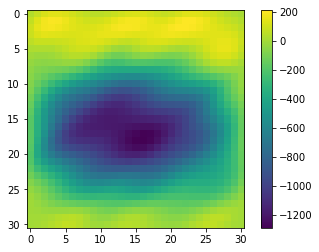

In [22]:
plt.imshow(DMM_U.reshape(sqrtinputsize,sqrtinputsize))
plt.colorbar()

**Plot Residual**

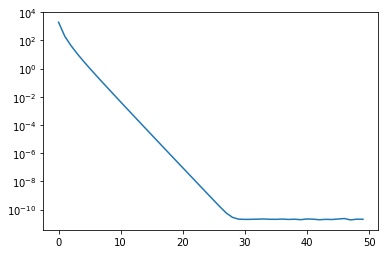

In [23]:
plt.semilogy(DMM_Res)

**Calculate Spectral Radius**

In [24]:
DMM_Radius = Rhonew
print('DMM_Radius = {}'.format(DMM_Radius))

DMM_Radius = 0.3665681744883609


R under log10(abs())


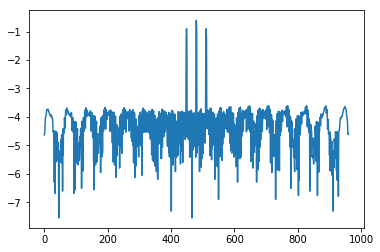

In [25]:
print("R under log10(abs())")
plt.plot(np.log10(np.abs(Rnew))[round(0.5*outputsize)][:])

## DMM with nine point scheme optimizer

**Build the stiff matrix**

In [26]:
num_levels=2
n=sqrtinputsize
kx = np.zeros([n,n+1])
ky = np.zeros([n+1,n])
for i in range(n):
    for j in range(n+1):
        kx[i][j] = a((j-0.5)*h,i*h)
for i in range(n+1):
    for j in range(n):
        ky[i][j] = a(j*h,(i-0.5)*h)    
A = gallery.nonlinearPoisson((n,n), kx, ky)

In [27]:
PR_stencil_type = "m9p"
gmm = dgmg.DeepMG(A, PR_stencil_type=PR_stencil_type, max_levels=num_levels)
num_iter = 2500
step_size = 1e-4
opt_par = gmm.optimize(num_iter=num_iter, step_size=step_size)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]


Iteration 100/2500
Upper bound estimation = 0.2153380639515685
Iteration 200/2500
Upper bound estimation = 0.2039128978237852
Iteration 300/2500
Upper bound estimation = 0.1915441162636323
Iteration 400/2500
Upper bound estimation = 0.18016441605054553
Iteration 500/2500
Upper bound estimation = 0.17135801510349155
Iteration 600/2500
Upper bound estimation = 0.16529794354543667
Iteration 700/2500
Upper bound estimation = 0.15916533267458446
Iteration 800/2500
Upper bound estimation = 0.15133022104968036
Iteration 900/2500
Upper bound estimation = 0.1450224073377872
Iteration 1000/2500
Upper bound estimation = 0.13971269414692478
Iteration 1100/2500
Upper bound estimation = 0.13332531974864928
Iteration 1200/2500
Upper bound estimation = 0.12979282281768714
Iteration 1300/2500
Upper bound estimation = 0.1300094435905185
Iteration 1400/2500
Upper bound estimation = 0.12884997312702817
Iteration 1500/2500
Upper bound estimation = 0.1295890952245866
Iteration 1600/2500
Upper bound estimati

In [28]:
print(gmm)
convergence = gmm.get_optimizer_convergence()
conv_time = gmm.get_optimization_time()
gmm.update_prd(opt_par)
DMM_rho = gmm.compute_rho()
print("DMM rho = {}".format(DMM_rho))

Dimension of matrix A for levels:
Level = 0, dimension = (15, 15)
Level = 1, dimension = (31, 31)

DMM rho = 0.10923249248752923


[2.34897610e+03 3.42524660e+02 2.78804710e+01 1.75240023e+00
 7.91320133e-02 4.13237072e-03 3.47161303e-04 2.59544835e-05
 1.68063271e-06 1.74150974e-07 1.79880869e-08 1.83057351e-09
 1.89301345e-10 2.74218998e-11 1.29704463e-11 1.08526100e-11
 1.37269447e-11 1.17640621e-11 1.13537863e-11 1.24098925e-11
 1.25991404e-11 1.37841371e-11 1.27468594e-11 1.38777334e-11
 1.26903171e-11 1.21016706e-11 1.19358938e-11 1.28763250e-11
 1.46781971e-11 1.15548933e-11 1.20037607e-11 1.41535194e-11
 1.21927326e-11 1.40155667e-11 1.12162477e-11 1.33253684e-11
 1.24152222e-11 1.42631855e-11 1.22482157e-11 1.25244644e-11
 1.18982974e-11 1.18498996e-11 1.12243558e-11 1.11415062e-11
 1.30113784e-11 1.06580994e-11 1.25491024e-11 1.25453108e-11
 1.24832594e-11 1.29713901e-11]


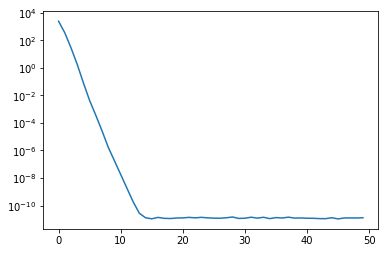

In [29]:
x = gmm.solve(RightF, np.random.randn(A.shape), tol=0, max_iter=50)
print(gmm.get_gmg_convergence())
plt.semilogy(gmm.get_gmg_convergence())

In [30]:
np.linalg.norm(Ureal - x,np.inf)

1290.2722716827034

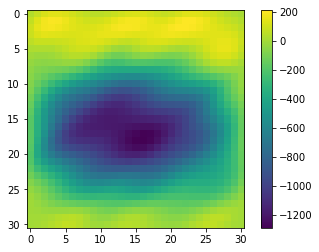

In [31]:
x = x.reshape(A.dim)
plt.imshow(x)
plt.colorbar()

In [32]:
np.set_printoptions(threshold=np.inf)
print("omega = {}".format(opt_par[2]))

omega = 0.7893253427758906


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log10
  return f_raw(*args, **kwargs)


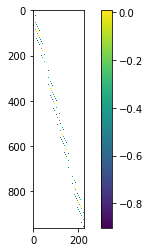

In [33]:
P = opt_par[0][0]
k = int(2**(np.log2(n+1)-1)-1) 
P_Matrix = np.zeros([n**2,k**2])
for i in range(k):
    for j in range(k):
        C = P[i][j]
        for l in range(3):
            for m in range(3):
                P_Matrix[n*(2*i+l)+(2*j+m)][k*i+j] = C[l][m]
plt.imshow(np.log10(np.abs(P_Matrix)))
plt.colorbar()

P under log10(abs())


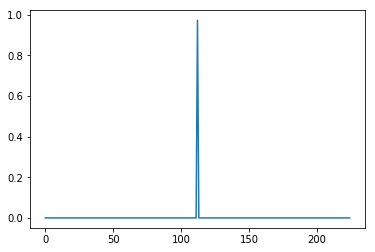

In [34]:
print("P under log10(abs())")
plt.plot(P_Matrix[round(0.5*inputsize)][:])

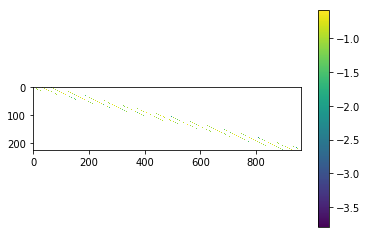

In [35]:
R = opt_par[1][0]
R_Matrix = np.zeros([k**2,n**2])
for i in range(k):
    for j in range(k):
        C = R[i][j]
        for l in range(3):
            for m in range(3):
                R_Matrix[k*i+j][n*(2*i+l)+(2*j+m)] = C[l][m]
plt.imshow(np.log10(np.abs(R_Matrix)))
plt.colorbar()

R under log10(abs())


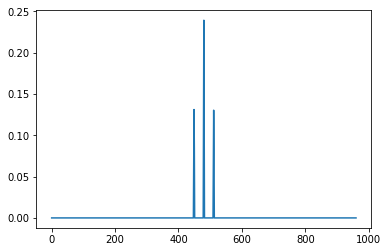

In [36]:
print("R under log10(abs())")
plt.plot(R_Matrix[:][round(0.5*outputsize)])

## Compare

Text(0, 0.5, 'Residual')

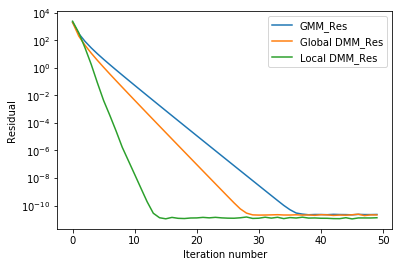

In [37]:
plt.semilogy(GMM_Res, label = 'GMM_Res')
plt.semilogy(DMM_Res, label = 'Global DMM_Res')
plt.semilogy(gmm.get_gmg_convergence(), label = 'Local DMM_Res')
plt.legend(loc='upper right')
plt.xlabel('Iteration number')
plt.ylabel('Residual')